In [ ]:
!pip install pydicom scikit-image tcia-utils pycox lifelines torchtuples

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.transform import resize
import os
import glob
import pydicom
from tcia_utils import nbia
import zipfile
import shutil
from scipy.ndimage import zoom

In [ ]:
DATA_FILE_NAME = '/content/Clinical_and_Other_Features.xlsx'
ANNOTATION_FILE_NAME = '/content/Annotation_Boxes.xlsx'
SERIES_FILE_NAME = '/content/series-data1762108734220.csv'

CLINICAL_COLS_MAPPING = {
    'ER': 'ER',
    'PR': 'PR',
    'HER2': 'HER2',
    'Oncotype score': 'Oncotype score',
    'Tumor Size (cm)': 'Tumor Size (cm)',
    'Tumor Grade': 'Tumor Grade',
    'Nottingham grade': 'Nottingham grade',
    'Age at mammo (days)': 'Age at mammo (days)',
    'Adjuvant Chemotherapy': 'Adjuvant Chemotherapy',
    'Neoadjuvant Chemotherapy': 'Neoadjuvant Chemotherapy',
    'Neoadjuvant Endocrine Therapy Medications': 'Neoadjuvant Endocrine Therapy Medications',
    'Staging(Tumor Size)# [T]': 'Staging(Tumor Size)# [T]',
    'Staging(Nodes)#(Nx replaced by -1)[N]': 'Staging(Nodes)#(Nx replaced by -1)[N]',
    'Staging(Metastasis)#(Mx -replaced by -1)[M]': 'Staging(Metastasis)#(Mx -replaced by -1)[M]',
    'Histologic type': 'Histologic type'
}

In [ ]:
COL_PATIENT_ID = 'Patient ID'
COL_RECURRENCE_STATUS = 'Recurrence event(s)'
COL_LOCAL_TIME = 'Days to local recurrence (from the date of diagnosis)'
COL_DISTANT_TIME = 'Days to distant recurrence(from the date of diagnosis)'
COL_FOLLOWUP = 'Age at last contact in EMR f/u(days)(from the date of diagnosis) ,last time patient known to be alive, unless age of death is reported(in such case the age of death'

patient_ids_to_keep = [f'Breast_MRI_{i:03d}' for i in range(1, 101)]

In [ ]:
# =====================================================
# 1. KLİNİK VERİLERİ YÜKLE VE TEMİZLE
# =====================================================
print("="*80)
print("1. KLİNİK VERİLERİ YÜKLEME VE TEMİZLEME")
print("="*80)

# Excel dosyasını oku
df_raw = pd.read_excel(DATA_FILE_NAME, header=1)

# Sütun isimlerindeki yeni satır karakterlerini temizle
df_raw.columns = df_raw.columns.str.replace('\n', ' ', regex=False).str.strip()

# Sadece seçili hastaları filtrele
df_meta = df_raw[df_raw[COL_PATIENT_ID].isin(patient_ids_to_keep)].copy()
print(f"\n{len(df_meta)} hasta seçildi")

# =====================================================
# 2. SURVIVAL VERİLERİNİ HAZIRLA - DÜZELTİLMİŞ!
# =====================================================
print("\n" + "="*80)
print("2. SURVIVAL VERİLERİNİ HAZIRLAMA - DÜZELTİLMİŞ")
print("="*80)

df_survival_raw = df_meta[[COL_PATIENT_ID, COL_RECURRENCE_STATUS,
                           COL_LOCAL_TIME, COL_DISTANT_TIME, COL_FOLLOWUP]].copy()

# Zaman sütunlarını numeric'e çevir
time_cols = [COL_LOCAL_TIME, COL_DISTANT_TIME, COL_FOLLOWUP]
for col in time_cols:
    df_survival_raw[col] = pd.to_numeric(df_survival_raw[col], errors='coerce')

print("\nEvent değerleri kontrol ediliyor...")
print(f"Orijinal Recurrence event(s) değerleri: {df_survival_raw[COL_RECURRENCE_STATUS].unique()}")

# Event sütununu direkt integer'a çevir
df_survival_raw['Event'] = pd.to_numeric(df_survival_raw[COL_RECURRENCE_STATUS], errors='coerce').fillna(0).astype(int)

print(f"Event dağılımı:")
print(df_survival_raw['Event'].value_counts())

# Recurrence olan hastalar
recurrent_patients = df_survival_raw[df_survival_raw['Event'] == 1][COL_PATIENT_ID].tolist()
print(f"\nRecurrence olan hastalar ({len(recurrent_patients)} adet):")
for p in recurrent_patients:
    print(f"  - {p}")

# Recurrence zamanını hesapla
df_survival_raw['Recurrence_Time'] = df_survival_raw[[COL_LOCAL_TIME, COL_DISTANT_TIME]].min(axis=1)

# Final time değerini belirle
df_survival_raw['Time'] = np.where(
    df_survival_raw['Event'] == 1,
    df_survival_raw['Recurrence_Time'],
    df_survival_raw[COL_FOLLOWUP]
)

# NaN değerleri temizle
df_survival_raw.dropna(subset=['Time', 'Event'], inplace=True)

# Survival dataframe'i oluştur
df_survival = df_survival_raw[[COL_PATIENT_ID, 'Time', 'Event']].copy()
df_survival.rename(columns={COL_PATIENT_ID: 'Patient ID'}, inplace=True)

print(f"\nSurvival verisi hazırlandı: {len(df_survival)} hasta")
print(f"Event=1 olan hasta sayısı: {(df_survival['Event'] == 1).sum()}")

# =====================================================
# 3. KLİNİK VERİLERİ ÇIKAR
# =====================================================
print("\n" + "="*80)
print("3. KLİNİK VERİLERİ ÇIKARMA")
print("="*80)

# Klinik verileri çıkar
clinical_features = []
missing_columns = []

for col_key, col_name in CLINICAL_COLS_MAPPING.items():
    if col_name in df_meta.columns:
        clinical_features.append(col_name)
    else:
        missing_columns.append(col_name)

if missing_columns:
    print(f"\n⚠️ Uyarı: Şu sütunlar bulunamadı: {missing_columns}")

# Klinik verileri içeren dataframe oluştur
df_clinical = df_meta[['Patient ID'] + clinical_features].copy()

print(f"\n{len(clinical_features)} klinik özellik çıkarıldı")

# =====================================================
# 4. KATEGORİK VERİLERİ ENCODE ET
# =====================================================
print("\n" + "="*80)
print("4. KATEGORİK VERİLERİ ENCODE ETME")
print("="*80)

# Veriler zaten 0/1 olarak kodlanmış, direkt kopyala
df_clinical['ER_encoded'] = df_clinical['ER']
df_clinical['PR_encoded'] = df_clinical['PR']
df_clinical['HER2_encoded'] = df_clinical['HER2']
df_clinical['Adjuvant Chemotherapy_encoded'] = df_clinical['Adjuvant Chemotherapy']
df_clinical['Neoadjuvant Chemotherapy_encoded'] = df_clinical['Neoadjuvant Chemotherapy']
df_clinical['Neoadjuvant Endocrine Therapy_encoded'] = df_clinical['Neoadjuvant Endocrine Therapy Medications']

# Histologic type için encoding
if 'Histologic type' in df_clinical.columns:
    df_clinical['Histologic type_encoded'] = df_clinical['Histologic type'].fillna(-1)

print("Encoding tamamlandı")

# =====================================================
# 5. ANNOTATION VERİLERİNİ YÜKLE
# =====================================================
print("\n" + "="*80)
print("5. ANNOTATION VERİLERİNİ YÜKLEME")
print("="*80)

df_anno = pd.read_excel(ANNOTATION_FILE_NAME)
df_anno_filtered = df_anno[df_anno['Patient ID'].isin(patient_ids_to_keep)].copy()

df_annotations = df_anno_filtered[['Patient ID', 'Start Row', 'End Row',
                                   'Start Column', 'End Column',
                                   'Start Slice', 'End Slice']].copy()
df_annotations.dropna(subset=['Start Slice', 'End Slice'], inplace=True)

print(f"Annotation verisi hazırlandı: {len(df_annotations)} hasta")

# =====================================================
# 6. SERIES VERİLERİNİ YÜKLE
# =====================================================
print("\n" + "="*80)
print("6. SERIES VERİLERİNİ YÜKLEME")
print("="*80)

df_series = pd.read_csv(SERIES_FILE_NAME, low_memory=False)
df_series.columns = df_series.columns.str.replace('"', '').str.strip()

df_series_filtered = df_series[df_series['PatientID'].isin(patient_ids_to_keep)].copy()

# Dinamik serileri filtrele
df_series_filtered = df_series_filtered[
    df_series_filtered['SeriesDescription'].str.contains('dyn', na=False, case=False) |
    df_series_filtered['SeriesDescription'].str.contains('pass', na=False, case=False)
].copy()

df_series_filtered['SeriesNumber'] = pd.to_numeric(df_series_filtered['SeriesNumber'], errors='coerce')
df_series_filtered.sort_values(by=['PatientID', 'SeriesNumber'], inplace=True)

df_series_cleaned = df_series_filtered.groupby('PatientID').first().reset_index()
df_series_final = df_series_cleaned[['PatientID', 'SeriesInstanceUID']].copy()
df_series_final.rename(columns={'PatientID': 'Patient ID'}, inplace=True)

print(f"Series verisi hazırlandı: {len(df_series_final)} hasta")

# =====================================================
# 7. TÜM VERİLERİ BİRLEŞTİR
# =====================================================
print("\n" + "="*80)
print("7. TÜM VERİLERİ BİRLEŞTİRME")
print("="*80)

# Önce survival ve annotation'ları birleştir
df_merged = pd.merge(df_survival, df_annotations, on='Patient ID', how='inner')
print(f"Survival + Annotations: {len(df_merged)} hasta")
print(f"  Event=1 olan: {(df_merged['Event'] == 1).sum()} hasta")

# Series verilerini ekle
df_merged = pd.merge(df_merged, df_series_final, on='Patient ID', how='inner')
print(f"+ Series: {len(df_merged)} hasta")
print(f"  Event=1 olan: {(df_merged['Event'] == 1).sum()} hasta")

# Klinik verileri ekle
df_final = pd.merge(df_merged, df_clinical, on='Patient ID', how='inner')
print(f"+ Clinical: {len(df_final)} hasta")
print(f"  Event=1 olan: {(df_final['Event'] == 1).sum()} hasta")

# =====================================================
# 8. FINAL METADATA'YI KAYDET
# =====================================================
print("\n" + "="*80)
print("8. FINAL METADATA KAYDETME")
print("="*80)

output_path = "final_metadata_with_clinical_CORRECTED.csv"
df_final.to_csv(output_path, index=False)

print(f"\n✓ Final metadata kaydedildi: {output_path}")
print(f"  Toplam hasta: {len(df_final)}")
print(f"  Event=0 (No recurrence): {(df_final['Event'] == 0).sum()}")
print(f"  Event=1 (Recurrence): {(df_final['Event'] == 1).sum()}")

# =====================================================
# 9. VERİ KALİTESİ RAPORU
# =====================================================
print("\n" + "="*80)
print("9. VERİ KALİTESİ RAPORU")
print("="*80)

# Event dağılımı
print("\n📊 Event Dağılımı:")
event_counts = df_final['Event'].value_counts()
for event, count in event_counts.items():
    pct = count / len(df_final) * 100
    print(f"  Event={event}: {count} hasta (%{pct:.1f})")

# Recurrence olan hastaların analizi
if (df_final['Event'] == 1).sum() > 0:
    print("\n📊 Recurrence Olan Hastaların Özellikleri:")
    recurrent = df_final[df_final['Event'] == 1]

    print(f"\nRecurrence zamanları:")
    print(f"  Ortalama: {recurrent['Time'].mean():.1f} gün")
    print(f"  Median: {recurrent['Time'].median():.1f} gün")
    print(f"  Min: {recurrent['Time'].min():.1f} gün")
    print(f"  Max: {recurrent['Time'].max():.1f} gün")

    print(f"\nBiyomarker durumu:")
    if len(recurrent) > 0:
        er_pos = recurrent['ER'].sum()
        pr_pos = recurrent['PR'].sum()
        her2_pos = recurrent['HER2'].sum()
        print(f"  ER+: {er_pos}/{len(recurrent)}")
        print(f"  PR+: {pr_pos}/{len(recurrent)}")
        print(f"  HER2+: {her2_pos}/{len(recurrent)}")

        # Triple negative kontrol
        tn = ((recurrent['ER'] == 0) & (recurrent['PR'] == 0) & (recurrent['HER2'] == 0)).sum()
        print(f"  Triple Negative: {tn}/{len(recurrent)}")

# Tumor grade dağılımı
print("\n📊 Tumor Grade Dağılımı:")
grade_dist = df_final['Tumor Grade'].value_counts().sort_index()
for grade, count in grade_dist.items():
    pct = count / len(df_final) * 100
    print(f"  Grade {int(grade)}: {count} hasta (%{pct:.1f})")

# Biyomarker dağılımı
print("\n📊 Genel Biyomarker Dağılımı:")
er_pos = df_final['ER'].sum()
pr_pos = df_final['PR'].sum()
her2_pos = df_final['HER2'].sum()
triple_negative = ((df_final['ER'] == 0) & (df_final['PR'] == 0) & (df_final['HER2'] == 0)).sum()

print(f"  ER Pozitif: {er_pos}/{len(df_final)} (%{er_pos/len(df_final)*100:.1f})")
print(f"  PR Pozitif: {pr_pos}/{len(df_final)} (%{pr_pos/len(df_final)*100:.1f})")
print(f"  HER2 Pozitif: {her2_pos}/{len(df_final)} (%{her2_pos/len(df_final)*100:.1f})")
print(f"  Triple Negative: {triple_negative}/{len(df_final)} (%{triple_negative/len(df_final)*100:.1f})")

print("\n" + "="*80)
print("✅ İŞLEM BAŞARIYLA TAMAMLANDI!")
print("="*80)
print("\nArtık survival analizi yapabilirsiniz!")
print("Event=1 olan hastalar doğru şekilde işaretlendi.")


1. KLİNİK VERİLERİ YÜKLEME VE TEMİZLEME

100 hasta seçildi

2. SURVIVAL VERİLERİNİ HAZIRLAMA - DÜZELTİLMİŞ

Event değerleri kontrol ediliyor...
Orijinal Recurrence event(s) değerleri: [0 1]
Event dağılımı:
Event
0    90
1    10
Name: count, dtype: int64

Recurrence olan hastalar (10 adet):
  - Breast_MRI_010
  - Breast_MRI_012
  - Breast_MRI_028
  - Breast_MRI_042
  - Breast_MRI_043
  - Breast_MRI_047
  - Breast_MRI_053
  - Breast_MRI_060
  - Breast_MRI_068
  - Breast_MRI_094

Survival verisi hazırlandı: 76 hasta
Event=1 olan hasta sayısı: 10

3. KLİNİK VERİLERİ ÇIKARMA

15 klinik özellik çıkarıldı

4. KATEGORİK VERİLERİ ENCODE ETME
Encoding tamamlandı

5. ANNOTATION VERİLERİNİ YÜKLEME
Annotation verisi hazırlandı: 100 hasta

6. SERIES VERİLERİNİ YÜKLEME
Series verisi hazırlandı: 98 hasta

7. TÜM VERİLERİ BİRLEŞTİRME
Survival + Annotations: 76 hasta
  Event=1 olan: 10 hasta
+ Series: 74 hasta
  Event=1 olan: 10 hasta


/tmp/ipython-input-2111303358.py:110: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clinical['Histologic type_encoded'] = df_clinical['Histologic type'].fillna(-1)


+ Clinical: 74 hasta
  Event=1 olan: 10 hasta

8. FINAL METADATA KAYDETME

✓ Final metadata kaydedildi: final_metadata_with_clinical_CORRECTED.csv
  Toplam hasta: 74
  Event=0 (No recurrence): 64
  Event=1 (Recurrence): 10

9. VERİ KALİTESİ RAPORU

📊 Event Dağılımı:
  Event=0: 64 hasta (%86.5)
  Event=1: 10 hasta (%13.5)

📊 Recurrence Olan Hastaların Özellikleri:

Recurrence zamanları:
  Ortalama: 845.7 gün
  Median: 947.0 gün
  Min: 197.0 gün
  Max: 1526.0 gün

Biyomarker durumu:
  ER+: 3/10
  PR+: 2/10
  HER2+: 2/10
  Triple Negative: 6/10

📊 Tumor Grade Dağılımı:
  Grade 1: 4 hasta (%5.4)
  Grade 2: 9 hasta (%12.2)
  Grade 3: 60 hasta (%81.1)

📊 Genel Biyomarker Dağılımı:
  ER Pozitif: 52/74 (%70.3)
  PR Pozitif: 45/74 (%60.8)
  HER2 Pozitif: 19/74 (%25.7)
  Triple Negative: 16/74 (%21.6)

✅ İŞLEM BAŞARIYLA TAMAMLANDI!

Artık survival analizi yapabilirsiniz!
Event=1 olan hastalar doğru şekilde işaretlendi.


In [ ]:
df_raw = pd.read_excel(DATA_FILE_NAME, header=1)
df_raw.columns = df_raw.columns.str.replace('\n', ' ', regex=False).str.strip()

df_meta = df_raw[df_raw[COL_PATIENT_ID].isin(patient_ids_to_keep)].copy()

df_survival_raw = df_meta[[COL_PATIENT_ID, COL_RECURRENCE_STATUS, COL_LOCAL_TIME, COL_DISTANT_TIME, COL_FOLLOWUP]].copy()

time_cols = [COL_LOCAL_TIME, COL_DISTANT_TIME, COL_FOLLOWUP]
for col in time_cols:
    df_survival_raw[col] = pd.to_numeric(df_survival_raw[col], errors='coerce')

event_mapping = {'Yes': 1, 'No': 0}
df_survival_raw['Event'] = df_survival_raw[COL_RECURRENCE_STATUS].map(event_mapping).fillna(0).astype(int)

df_survival_raw['Recurrence_Time'] = df_survival_raw[[COL_LOCAL_TIME, COL_DISTANT_TIME]].min(axis=1)

df_survival_raw['Time'] = np.where(df_survival_raw['Event'] == 1,
                                    df_survival_raw['Recurrence_Time'],
                                    df_survival_raw[COL_FOLLOWUP])

df_survival_raw.dropna(subset=['Time', 'Event'], inplace=True)
df_survival = df_survival_raw[[COL_PATIENT_ID, 'Time', 'Event']].copy()
df_survival.rename(columns={COL_PATIENT_ID: 'Patient ID'}, inplace=True)



In [ ]:
df_anno = pd.read_excel(ANNOTATION_FILE_NAME)
df_anno_filtered = df_anno[df_anno['Patient ID'].isin(patient_ids_to_keep)].copy()

df_annotations = df_anno_filtered[['Patient ID', 'Start Row', 'End Row', 'Start Column', 'End Column', 'Start Slice', 'End Slice']].copy()
df_annotations.dropna(subset=['Start Slice', 'End Slice'], inplace=True)

print("2. Annotation Data Preparation Complete.")

2. Annotation Data Preparation Complete.


In [ ]:
df_series = pd.read_csv(SERIES_FILE_NAME, low_memory=False)
df_series.columns = df_series.columns.str.replace('"', '').str.strip()

df_series_filtered = df_series[df_series['PatientID'].isin(patient_ids_to_keep)].copy()

df_series_filtered = df_series_filtered[
    df_series_filtered['SeriesDescription'].str.contains('dyn', na=False, case=False) |
    df_series_filtered['SeriesDescription'].str.contains('pass', na=False, case=False)
].copy()

df_series_filtered['SeriesNumber'] = pd.to_numeric(df_series_filtered['SeriesNumber'], errors='coerce')
df_series_filtered.sort_values(by=['PatientID', 'SeriesNumber'], inplace=True)

df_series_cleaned = df_series_filtered.groupby('PatientID').first().reset_index()
df_series_final = df_series_cleaned[['PatientID', 'SeriesInstanceUID']].copy()
df_series_final.rename(columns={'PatientID': 'Patient ID'}, inplace=True)

print("3. Series Data Preparation Complete.")


3. Series Data Preparation Complete.


In [ ]:
METADATA_OUTPUT_PATH = "final_metadata_for_3D_processing.csv"
if not df_survival.empty and not df_annotations.empty and not df_series_final.empty:
    df_merged = pd.merge(df_survival, df_annotations, on='Patient ID', how='inner')
    df_final_metadata = pd.merge(df_merged, df_series_final, on='Patient ID', how='inner')

    df_final_metadata.to_csv(METADATA_OUTPUT_PATH, index=False)

    print(f"\n--- Meta Veri Birleştirme Tamamlandı. Nihai Hasta Sayısı: {len(df_final_metadata)}")


--- Meta Veri Birleştirme Tamamlandı. Nihai Hasta Sayısı: 72


In [ ]:
try:

    df_series = pd.read_csv(SERIES_FILE_NAME, low_memory=False)
    df_series.columns = df_series.columns.str.replace('"', '').str.strip()
    series_uids = df_series['SeriesInstanceUID'].unique().tolist()

    # İndirilecek Serilerin listesini bir dosyaya kaydet (API için gerekli format)
    series_list_file = 'series_uids_to_download.txt'
    with open(series_list_file, 'w') as f:
        for uid in series_uids:
            f.write(f"{uid}\n")

    print(f"Toplam {len(series_uids)} seriye ait UID'ler '{series_list_file}' dosyasına kaydedildi.")

except Exception as e:
    print(f"Series Data okuma hatası: {e}")
    exit()

Toplam 557 seriye ait UID'ler 'series_uids_to_download.txt' dosyasına kaydedildi.


In [ ]:
# Ayarlar
METADATA_PATH = '/content/final_metadata_for_3D_processing.csv'
DOWNLOAD_DIR = '/content/tcia_downloads'
DICOM_ROOT_PATH = '/content/tcia_data/dicom_images'

os.makedirs(DOWNLOAD_DIR, exist_ok=True)
os.makedirs(DICOM_ROOT_PATH, exist_ok=True)

# Metadata'yı yükle
df_metadata = pd.read_csv(METADATA_PATH)
print(f"Toplam {len(df_metadata)} hasta için DICOM indirme işlemi başlayacak.\n")

# İndirme istatistikleri
successful_downloads = []
failed_downloads = []

print("=" * 80)
print("DICOM İNDİRME İŞLEMİ BAŞLIYOR")
print("=" * 80)

for idx, row in tqdm(df_metadata.iterrows(), total=len(df_metadata), desc="İndiriliyor"):
    patient_id = row['Patient ID']
    series_uid = row['SeriesInstanceUID']

    print(f"\n{'='*60}")
    print(f"İşleniyor: {patient_id}")
    print(f"Series UID: {series_uid}")
    print(f"{'='*60}")

    # Hasta klasörünü oluştur
    patient_dir = os.path.join(DICOM_ROOT_PATH, patient_id)
    os.makedirs(patient_dir, exist_ok=True)

    # Series klasörünü oluştur
    series_dir = os.path.join(patient_dir, series_uid)

    # Eğer bu series zaten indirildiyse atla
    if os.path.exists(series_dir) and len(os.listdir(series_dir)) > 0:
        print(f"✓ {patient_id} zaten indirilmiş, atlanıyor...")
        successful_downloads.append(patient_id)
        continue

    try:
        patient_download_dir = os.path.join(DOWNLOAD_DIR, patient_id)
        os.makedirs(patient_download_dir, exist_ok=True)

        # TCIA'dan series'i indir
        print(f"📥 İndiriliyor...")

        nbia.downloadSeries(
            series_data=[series_uid],
            path=patient_download_dir,
            input_type="list"
        )

        print(f"✓ İndirme tamamlandı")

        downloaded_files = []
        for root, dirs, files in os.walk(patient_download_dir):
            for file in files:
                file_path = os.path.join(root, file)
                # Gizli dosyaları, metadata ve ZIP dosyalarını atla
                if (not file.startswith('.') and
                    file.lower() not in ['dicomdir', 'version.txt'] and
                    not file.endswith('.zip')):
                    downloaded_files.append(file_path)

        if len(downloaded_files) > 0:
            os.makedirs(series_dir, exist_ok=True)

            # DICOM dosyalarını series klasörüne kopyala
            print(f"📂 {len(downloaded_files)} dosya taşınıyor...")
            for dicom_file in downloaded_files:
                dest_file = os.path.join(series_dir, os.path.basename(dicom_file))
                shutil.copy2(dicom_file, dest_file)

            print(f"✓ {len(downloaded_files)} DICOM dosyası kaydedildi")
            successful_downloads.append(patient_id)
        else:
            print(f"⚠️ İndirilen klasörde DICOM dosyası bulunamadı!")
            failed_downloads.append(patient_id)

        # Geçici klasörü temizle
        if os.path.exists(patient_download_dir):
            shutil.rmtree(patient_download_dir)

    except Exception as e:
        print(f"❌ Hata: {patient_id} - {str(e)}")
        failed_downloads.append(patient_id)

        # Hata durumunda geçici klasörü temizle
        patient_download_dir = os.path.join(DOWNLOAD_DIR, patient_id)
        if os.path.exists(patient_download_dir):
            try:
                shutil.rmtree(patient_download_dir)
            except:
                pass
        continue

# Özet rapor
print("\n" + "=" * 80)
print("İNDİRME İŞLEMİ TAMAMLANDI")
print("=" * 80)
print(f"✓ Başarılı: {len(successful_downloads)}/{len(df_metadata)}")
print(f"❌ Başarısız: {len(failed_downloads)}/{len(df_metadata)}")

if len(failed_downloads) > 0:
    print(f"\nBaşarısız hastalar: {failed_downloads}")

# Klasör yapısını göster
print("\n" + "=" * 80)
print("OLUŞTURULAN KLASÖR YAPISI")
print("=" * 80)
patient_dirs = [d for d in os.listdir(DICOM_ROOT_PATH) if os.path.isdir(os.path.join(DICOM_ROOT_PATH, d))]
for i, patient_dir in enumerate(patient_dirs[:5]):
    patient_path = os.path.join(DICOM_ROOT_PATH, patient_dir)
    print(f"\n📁 {patient_dir}/")
    for series_dir in os.listdir(patient_path):
        series_path = os.path.join(patient_path, series_dir)
        if os.path.isdir(series_path):
            num_files = len(os.listdir(series_path))
            print(f"  └── {series_dir[:50]}.../ ({num_files} DICOM dosyası)")

Toplam 72 hasta için DICOM indirme işlemi başlayacak.

DICOM İNDİRME İŞLEMİ BAŞLIYOR


İndiriliyor:   0%|          | 0/72 [00:00<?, ?it/s]


İşleniyor: Breast_MRI_001
Series UID: 1.3.6.1.4.1.14519.5.2.1.185777849803665244536713316058283493877
📥 İndiriliyor...


İndiriliyor:   1%|▏         | 1/72 [00:14<16:40, 14.08s/it]

✓ İndirme tamamlandı
📂 161 dosya taşınıyor...
✓ 161 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_002
Series UID: 1.3.6.1.4.1.14519.5.2.1.292087950444413314643924739363083325442
📥 İndiriliyor...


İndiriliyor:   3%|▎         | 2/72 [00:25<14:34, 12.49s/it]

✓ İndirme tamamlandı
📂 143 dosya taşınıyor...
✓ 143 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_004
Series UID: 1.3.6.1.4.1.14519.5.2.1.239894618047060046180456504190040557340
📥 İndiriliyor...


İndiriliyor:   4%|▍         | 3/72 [00:39<15:14, 13.26s/it]

✓ İndirme tamamlandı
📂 165 dosya taşınıyor...
✓ 165 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_005
Series UID: 1.3.6.1.4.1.14519.5.2.1.308267282790822635275517329397281651993
📥 İndiriliyor...


İndiriliyor:   6%|▌         | 4/72 [00:53<15:04, 13.30s/it]

✓ İndirme tamamlandı
📂 161 dosya taşınıyor...
✓ 161 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_007
Series UID: 1.3.6.1.4.1.14519.5.2.1.94812126929933158508977354689530276950
📥 İndiriliyor...
✓ İndirme tamamlandı
📂 209 dosya taşınıyor...


İndiriliyor:   7%|▋         | 5/72 [01:09<16:09, 14.47s/it]

✓ 209 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_008
Series UID: 1.3.6.1.4.1.14519.5.2.1.330441786668007360375584042791829664921
📥 İndiriliyor...


İndiriliyor:   8%|▊         | 6/72 [01:22<15:25, 14.02s/it]

✓ İndirme tamamlandı
📂 161 dosya taşınıyor...
✓ 161 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_009
Series UID: 1.3.6.1.4.1.14519.5.2.1.195599593590134921565234265546312466184
📥 İndiriliyor...


İndiriliyor:  10%|▉         | 7/72 [01:35<14:52, 13.74s/it]

✓ İndirme tamamlandı
📂 157 dosya taşınıyor...
✓ 157 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_010
Series UID: 1.3.6.1.4.1.14519.5.2.1.139066171032552599962813047852732821046
📥 İndiriliyor...


İndiriliyor:  11%|█         | 8/72 [01:46<13:41, 12.84s/it]

✓ İndirme tamamlandı
📂 147 dosya taşınıyor...
✓ 147 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_012
Series UID: 1.3.6.1.4.1.14519.5.2.1.29690579104517430202999923277168936221
📥 İndiriliyor...


İndiriliyor:  12%|█▎        | 9/72 [02:00<13:48, 13.15s/it]

✓ İndirme tamamlandı
📂 179 dosya taşınıyor...
✓ 179 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_013
Series UID: 1.3.6.1.4.1.14519.5.2.1.261327906680477816301507667044294790045
📥 İndiriliyor...
✓ İndirme tamamlandı
📂 175 dosya taşınıyor...


İndiriliyor:  14%|█▍        | 10/72 [02:16<14:30, 14.04s/it]

✓ 175 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_014
Series UID: 1.3.6.1.4.1.14519.5.2.1.233223525749432793243874913361933782670
📥 İndiriliyor...


İndiriliyor:  15%|█▌        | 11/72 [02:33<15:09, 14.91s/it]

✓ İndirme tamamlandı
📂 177 dosya taşınıyor...
✓ 177 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_015
Series UID: 1.3.6.1.4.1.14519.5.2.1.114596793393111129527999604845449110851
📥 İndiriliyor...


İndiriliyor:  17%|█▋        | 12/72 [02:43<13:23, 13.40s/it]

✓ İndirme tamamlandı
📂 113 dosya taşınıyor...
✓ 113 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_017
Series UID: 1.3.6.1.4.1.14519.5.2.1.338179040328609777020335253349387119426
📥 İndiriliyor...


İndiriliyor:  18%|█▊        | 13/72 [02:59<14:03, 14.29s/it]

✓ İndirme tamamlandı
📂 177 dosya taşınıyor...
✓ 177 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_018
Series UID: 1.3.6.1.4.1.14519.5.2.1.266544402444296594499244935809844674410
📥 İndiriliyor...


İndiriliyor:  19%|█▉        | 14/72 [03:17<14:46, 15.29s/it]

✓ İndirme tamamlandı
📂 209 dosya taşınıyor...
✓ 209 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_019
Series UID: 1.3.6.1.4.1.14519.5.2.1.29840080323274044917609393923117431278
📥 İndiriliyor...


İndiriliyor:  21%|██        | 15/72 [03:27<13:02, 13.73s/it]

✓ İndirme tamamlandı
📂 161 dosya taşınıyor...
✓ 161 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_020
Series UID: 1.3.6.1.4.1.14519.5.2.1.19937839761165364551077012129788420070
📥 İndiriliyor...


İndiriliyor:  22%|██▏       | 16/72 [03:44<13:51, 14.84s/it]

✓ İndirme tamamlandı
📂 175 dosya taşınıyor...
✓ 175 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_021
Series UID: 1.3.6.1.4.1.14519.5.2.1.284279810676391467352803707565165173046
📥 İndiriliyor...


İndiriliyor:  24%|██▎       | 17/72 [04:01<14:06, 15.40s/it]

✓ İndirme tamamlandı
📂 177 dosya taşınıyor...
✓ 177 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_023
Series UID: 1.3.6.1.4.1.14519.5.2.1.267962074606775126305724610724557013819
📥 İndiriliyor...


İndiriliyor:  25%|██▌       | 18/72 [04:18<14:08, 15.71s/it]

✓ İndirme tamamlandı
📂 193 dosya taşınıyor...
✓ 193 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_024
Series UID: 1.3.6.1.4.1.14519.5.2.1.226511564379996779936321223505089264443
📥 İndiriliyor...


İndiriliyor:  26%|██▋       | 19/72 [04:35<14:21, 16.25s/it]

✓ İndirme tamamlandı
📂 181 dosya taşınıyor...
✓ 181 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_025
Series UID: 1.3.6.1.4.1.14519.5.2.1.143759667969157072659280822310240577160
📥 İndiriliyor...


İndiriliyor:  28%|██▊       | 20/72 [04:52<14:17, 16.48s/it]

✓ İndirme tamamlandı
📂 157 dosya taşınıyor...
✓ 157 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_026
Series UID: 1.3.6.1.4.1.14519.5.2.1.312099821756302215052773038149699657921
📥 İndiriliyor...


İndiriliyor:  29%|██▉       | 21/72 [05:12<14:55, 17.57s/it]

✓ İndirme tamamlandı
📂 209 dosya taşınıyor...
✓ 209 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_027
Series UID: 1.3.6.1.4.1.14519.5.2.1.34925734941628997819482417489200552800
📥 İndiriliyor...


İndiriliyor:  31%|███       | 22/72 [05:31<14:58, 17.96s/it]

✓ İndirme tamamlandı
📂 193 dosya taşınıyor...
✓ 193 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_028
Series UID: 1.3.6.1.4.1.14519.5.2.1.320596235836817677689318971087443086949
📥 İndiriliyor...


İndiriliyor:  32%|███▏      | 23/72 [05:49<14:32, 17.82s/it]

✓ İndirme tamamlandı
📂 209 dosya taşınıyor...
✓ 209 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_031
Series UID: 1.3.6.1.4.1.14519.5.2.1.32271769280516867077968870517885443849
📥 İndiriliyor...


İndiriliyor:  33%|███▎      | 24/72 [06:02<13:11, 16.49s/it]

✓ İndirme tamamlandı
📂 163 dosya taşınıyor...
✓ 163 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_033
Series UID: 1.3.6.1.4.1.14519.5.2.1.291169408076510421796474270381579061308
📥 İndiriliyor...


İndiriliyor:  35%|███▍      | 25/72 [06:16<12:27, 15.89s/it]

✓ İndirme tamamlandı
📂 175 dosya taşınıyor...
✓ 175 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_036
Series UID: 1.3.6.1.4.1.14519.5.2.1.16087570434918330661626493782492078090
📥 İndiriliyor...


İndiriliyor:  36%|███▌      | 26/72 [06:28<11:14, 14.66s/it]

✓ İndirme tamamlandı
📂 145 dosya taşınıyor...
✓ 145 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_037
Series UID: 1.3.6.1.4.1.14519.5.2.1.107431652861659968541636750780728692080
📥 İndiriliyor...


İndiriliyor:  38%|███▊      | 27/72 [06:36<09:30, 12.67s/it]

✓ İndirme tamamlandı
📂 145 dosya taşınıyor...
✓ 145 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_038
Series UID: 1.3.6.1.4.1.14519.5.2.1.29729530304446862903224614767939060939
📥 İndiriliyor...


İndiriliyor:  39%|███▉      | 28/72 [06:50<09:27, 12.89s/it]

✓ İndirme tamamlandı
📂 163 dosya taşınıyor...
✓ 163 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_039
Series UID: 1.3.6.1.4.1.14519.5.2.1.215323598942552944423557558057976720332
📥 İndiriliyor...


İndiriliyor:  40%|████      | 29/72 [07:04<09:29, 13.25s/it]

✓ İndirme tamamlandı
📂 161 dosya taşınıyor...
✓ 161 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_041
Series UID: 1.3.6.1.4.1.14519.5.2.1.236293724990342289056773559709687460093
📥 İndiriliyor...


İndiriliyor:  42%|████▏     | 30/72 [07:16<09:00, 12.87s/it]

✓ İndirme tamamlandı
📂 169 dosya taşınıyor...
✓ 169 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_042
Series UID: 1.3.6.1.4.1.14519.5.2.1.221170381134996777977524742188839012763
📥 İndiriliyor...


İndiriliyor:  43%|████▎     | 31/72 [07:31<09:14, 13.53s/it]

✓ İndirme tamamlandı
📂 193 dosya taşınıyor...
✓ 193 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_043
Series UID: 1.3.6.1.4.1.14519.5.2.1.6793813290723618656258406154497169878
📥 İndiriliyor...


İndiriliyor:  44%|████▍     | 32/72 [07:44<08:52, 13.32s/it]

✓ İndirme tamamlandı
📂 189 dosya taşınıyor...
✓ 189 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_044
Series UID: 1.3.6.1.4.1.14519.5.2.1.139830005215649431703224664916087614564
📥 İndiriliyor...


İndiriliyor:  46%|████▌     | 33/72 [07:56<08:23, 12.92s/it]

✓ İndirme tamamlandı
📂 129 dosya taşınıyor...
✓ 129 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_046
Series UID: 1.3.6.1.4.1.14519.5.2.1.35071805945810659801827406527930186176
📥 İndiriliyor...


İndiriliyor:  47%|████▋     | 34/72 [08:11<08:43, 13.77s/it]

✓ İndirme tamamlandı
📂 257 dosya taşınıyor...
✓ 257 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_047
Series UID: 1.3.6.1.4.1.14519.5.2.1.326479453329573379629531437860389646655
📥 İndiriliyor...


İndiriliyor:  49%|████▊     | 35/72 [08:26<08:39, 14.05s/it]

✓ İndirme tamamlandı
📂 161 dosya taşınıyor...
✓ 161 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_048
Series UID: 1.3.6.1.4.1.14519.5.2.1.14969191741802921952501527627204705242
📥 İndiriliyor...


İndiriliyor:  50%|█████     | 36/72 [08:38<08:03, 13.42s/it]

✓ İndirme tamamlandı
📂 177 dosya taşınıyor...
✓ 177 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_049
Series UID: 1.3.6.1.4.1.14519.5.2.1.132501221905270945660459892737712601188
📥 İndiriliyor...


İndiriliyor:  51%|█████▏    | 37/72 [08:47<06:57, 11.94s/it]

✓ İndirme tamamlandı
📂 165 dosya taşınıyor...
✓ 165 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_051
Series UID: 1.3.6.1.4.1.14519.5.2.1.56794322020151755238976088550992192797
📥 İndiriliyor...


İndiriliyor:  53%|█████▎    | 38/72 [09:02<07:18, 12.90s/it]

✓ İndirme tamamlandı
📂 201 dosya taşınıyor...
✓ 201 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_052
Series UID: 1.3.6.1.4.1.14519.5.2.1.70798754894919505130189475242845748104
📥 İndiriliyor...


İndiriliyor:  54%|█████▍    | 39/72 [09:11<06:25, 11.68s/it]

✓ İndirme tamamlandı
📂 129 dosya taşınıyor...
✓ 129 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_053
Series UID: 1.3.6.1.4.1.14519.5.2.1.74241649418310553104355428399612716045
📥 İndiriliyor...


İndiriliyor:  56%|█████▌    | 40/72 [09:25<06:37, 12.43s/it]

✓ İndirme tamamlandı
📂 177 dosya taşınıyor...
✓ 177 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_056
Series UID: 1.3.6.1.4.1.14519.5.2.1.139850215283081947717800868934651199320
📥 İndiriliyor...
✓ İndirme tamamlandı
📂 197 dosya taşınıyor...
✓ 197 DICOM dosyası kaydedildi


İndiriliyor:  57%|█████▋    | 41/72 [09:45<07:37, 14.76s/it]


İşleniyor: Breast_MRI_057
Series UID: 1.3.6.1.4.1.14519.5.2.1.87678102268025627030497449879227437755
📥 İndiriliyor...


İndiriliyor:  58%|█████▊    | 42/72 [09:56<06:45, 13.52s/it]

✓ İndirme tamamlandı
📂 113 dosya taşınıyor...
✓ 113 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_058
Series UID: 1.3.6.1.4.1.14519.5.2.1.62324880423140184499634168443775070972
📥 İndiriliyor...


İndiriliyor:  60%|█████▉    | 43/72 [10:13<07:03, 14.62s/it]

✓ İndirme tamamlandı
📂 161 dosya taşınıyor...
✓ 161 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_059
Series UID: 1.3.6.1.4.1.14519.5.2.1.154064829117936049483903250937179540958
📥 İndiriliyor...


İndiriliyor:  61%|██████    | 44/72 [10:26<06:41, 14.35s/it]

✓ İndirme tamamlandı
📂 183 dosya taşınıyor...
✓ 183 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_061
Series UID: 1.3.6.1.4.1.14519.5.2.1.108872398847262229983257156206321964740
📥 İndiriliyor...


İndiriliyor:  62%|██████▎   | 45/72 [10:36<05:46, 12.83s/it]

✓ İndirme tamamlandı
📂 175 dosya taşınıyor...
✓ 175 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_063
Series UID: 1.3.6.1.4.1.14519.5.2.1.168315594930362854551151707920774052894
📥 İndiriliyor...


İndiriliyor:  64%|██████▍   | 46/72 [10:47<05:19, 12.30s/it]

✓ İndirme tamamlandı
📂 177 dosya taşınıyor...
✓ 177 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_064
Series UID: 1.3.6.1.4.1.14519.5.2.1.147955914978633063127428256313532881801
📥 İndiriliyor...


İndiriliyor:  65%|██████▌   | 47/72 [10:53<04:24, 10.59s/it]

✓ İndirme tamamlandı
📂 163 dosya taşınıyor...
✓ 163 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_065
Series UID: 1.3.6.1.4.1.14519.5.2.1.240714660932545870112421181205343916686
📥 İndiriliyor...


İndiriliyor:  67%|██████▋   | 48/72 [11:04<04:13, 10.56s/it]

✓ İndirme tamamlandı
📂 175 dosya taşınıyor...
✓ 175 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_066
Series UID: 1.3.6.1.4.1.14519.5.2.1.202905879773278236988982540614886457408
📥 İndiriliyor...


İndiriliyor:  68%|██████▊   | 49/72 [11:26<05:21, 13.99s/it]

✓ İndirme tamamlandı
📂 169 dosya taşınıyor...
✓ 169 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_067
Series UID: 1.3.6.1.4.1.14519.5.2.1.281452407991579907074251042114361334335
📥 İndiriliyor...


İndiriliyor:  69%|██████▉   | 50/72 [11:48<06:00, 16.37s/it]

✓ İndirme tamamlandı
📂 161 dosya taşınıyor...
✓ 161 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_071
Series UID: 1.3.6.1.4.1.14519.5.2.1.318477618058194737038846033112793175876
📥 İndiriliyor...
✓ İndirme tamamlandı
📂 197 dosya taşınıyor...
✓ 197 DICOM dosyası kaydedildi


İndiriliyor:  71%|███████   | 51/72 [12:22<07:38, 21.83s/it]


İşleniyor: Breast_MRI_073
Series UID: 1.3.6.1.4.1.14519.5.2.1.321516416087971745456399513546601827064
📥 İndiriliyor...


İndiriliyor:  72%|███████▏  | 52/72 [12:47<07:32, 22.61s/it]

✓ İndirme tamamlandı
📂 177 dosya taşınıyor...
✓ 177 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_075
Series UID: 1.3.6.1.4.1.14519.5.2.1.172470906074490371450387947562117092981
📥 İndiriliyor...


İndiriliyor:  74%|███████▎  | 53/72 [13:14<07:35, 23.98s/it]

✓ İndirme tamamlandı
📂 209 dosya taşınıyor...
✓ 209 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_076
Series UID: 1.3.6.1.4.1.14519.5.2.1.53070276916821426141527702302285207761
📥 İndiriliyor...


İndiriliyor:  75%|███████▌  | 54/72 [13:31<06:35, 21.96s/it]

✓ İndirme tamamlandı
📂 161 dosya taşınıyor...
✓ 161 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_079
Series UID: 1.3.6.1.4.1.14519.5.2.1.233578463593248271866442260134838655641
📥 İndiriliyor...


İndiriliyor:  76%|███████▋  | 55/72 [13:45<05:30, 19.42s/it]

✓ İndirme tamamlandı
📂 155 dosya taşınıyor...
✓ 155 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_080
Series UID: 1.3.6.1.4.1.14519.5.2.1.283361298177602841933761857048859216840
📥 İndiriliyor...


İndiriliyor:  78%|███████▊  | 56/72 [13:58<04:42, 17.64s/it]

✓ İndirme tamamlandı
📂 161 dosya taşınıyor...
✓ 161 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_081
Series UID: 1.3.6.1.4.1.14519.5.2.1.211739877075780458739327107114122768499
📥 İndiriliyor...


İndiriliyor:  79%|███████▉  | 57/72 [14:14<04:17, 17.19s/it]

✓ İndirme tamamlandı
📂 177 dosya taşınıyor...
✓ 177 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_082
Series UID: 1.3.6.1.4.1.14519.5.2.1.203505445198377129570893210428900718180
📥 İndiriliyor...


İndiriliyor:  81%|████████  | 58/72 [14:38<04:26, 19.04s/it]

✓ İndirme tamamlandı
📂 177 dosya taşınıyor...
✓ 177 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_083
Series UID: 1.3.6.1.4.1.14519.5.2.1.33007642049222954263821501177553095855
📥 İndiriliyor...


İndiriliyor:  82%|████████▏ | 59/72 [14:51<03:45, 17.32s/it]

✓ İndirme tamamlandı
📂 161 dosya taşınıyor...
✓ 161 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_084
Series UID: 1.3.6.1.4.1.14519.5.2.1.159830811558532697237874075447510411694
📥 İndiriliyor...


İndiriliyor:  83%|████████▎ | 60/72 [15:07<03:23, 16.97s/it]

✓ İndirme tamamlandı
📂 209 dosya taşınıyor...
✓ 209 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_085
Series UID: 1.3.6.1.4.1.14519.5.2.1.288560241765226590970770089314025353108
📥 İndiriliyor...


İndiriliyor:  85%|████████▍ | 61/72 [15:22<02:58, 16.23s/it]

✓ İndirme tamamlandı
📂 145 dosya taşınıyor...
✓ 145 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_086
Series UID: 1.3.6.1.4.1.14519.5.2.1.238735150432802860027977259854459327592
📥 İndiriliyor...


İndiriliyor:  86%|████████▌ | 62/72 [15:38<02:41, 16.15s/it]

✓ İndirme tamamlandı
📂 209 dosya taşınıyor...
✓ 209 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_087
Series UID: 1.3.6.1.4.1.14519.5.2.1.160291102826376073287758099681184086082
📥 İndiriliyor...


İndiriliyor:  88%|████████▊ | 63/72 [15:54<02:25, 16.16s/it]

✓ İndirme tamamlandı
📂 157 dosya taşınıyor...
✓ 157 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_088
Series UID: 1.3.6.1.4.1.14519.5.2.1.337622850606008445372422691733142219746
📥 İndiriliyor...


İndiriliyor:  89%|████████▉ | 64/72 [16:09<02:07, 15.91s/it]

✓ İndirme tamamlandı
📂 181 dosya taşınıyor...
✓ 181 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_089
Series UID: 1.3.6.1.4.1.14519.5.2.1.276531013864972657958657280655479251376
📥 İndiriliyor...


İndiriliyor:  90%|█████████ | 65/72 [16:24<01:48, 15.51s/it]

✓ İndirme tamamlandı
📂 177 dosya taşınıyor...
✓ 177 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_090
Series UID: 1.3.6.1.4.1.14519.5.2.1.194651386297649379035931320896715949363
📥 İndiriliyor...


İndiriliyor:  92%|█████████▏| 66/72 [16:44<01:42, 17.03s/it]

✓ İndirme tamamlandı
📂 197 dosya taşınıyor...
✓ 197 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_093
Series UID: 1.3.6.1.4.1.14519.5.2.1.90733406630904723346126541471680434030
📥 İndiriliyor...


İndiriliyor:  93%|█████████▎| 67/72 [16:58<01:20, 16.08s/it]

✓ İndirme tamamlandı
📂 151 dosya taşınıyor...
✓ 151 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_094
Series UID: 1.3.6.1.4.1.14519.5.2.1.161605906936633376919025940744367844511
📥 İndiriliyor...


İndiriliyor:  94%|█████████▍| 68/72 [17:15<01:05, 16.40s/it]

✓ İndirme tamamlandı
📂 177 dosya taşınıyor...
✓ 177 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_095
Series UID: 1.3.6.1.4.1.14519.5.2.1.63763468510374293348169259506570403686
📥 İndiriliyor...


İndiriliyor:  96%|█████████▌| 69/72 [17:31<00:48, 16.24s/it]

✓ İndirme tamamlandı
📂 177 dosya taşınıyor...
✓ 177 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_097
Series UID: 1.3.6.1.4.1.14519.5.2.1.129967585192783878980707247369022773138
📥 İndiriliyor...


İndiriliyor:  97%|█████████▋| 70/72 [17:49<00:33, 16.82s/it]

✓ İndirme tamamlandı
📂 209 dosya taşınıyor...
✓ 209 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_098
Series UID: 1.3.6.1.4.1.14519.5.2.1.215645661485552270942305335804311878657
📥 İndiriliyor...


İndiriliyor:  99%|█████████▊| 71/72 [18:06<00:16, 16.76s/it]

✓ İndirme tamamlandı
📂 161 dosya taşınıyor...
✓ 161 DICOM dosyası kaydedildi

İşleniyor: Breast_MRI_100
Series UID: 1.3.6.1.4.1.14519.5.2.1.278020606757978835142633926156996271190
📥 İndiriliyor...


İndiriliyor: 100%|██████████| 72/72 [18:20<00:00, 15.29s/it]

✓ İndirme tamamlandı
📂 145 dosya taşınıyor...
✓ 145 DICOM dosyası kaydedildi

İNDİRME İŞLEMİ TAMAMLANDI
✓ Başarılı: 72/72
❌ Başarısız: 0/72

OLUŞTURULAN KLASÖR YAPISI

📁 Breast_MRI_031/
  └── 1.3.6.1.4.1.14519.5.2.1.32271769280516867077968870.../ (163 DICOM dosyası)

📁 Breast_MRI_002/
  └── 1.3.6.1.4.1.14519.5.2.1.29208795044441331464392473.../ (143 DICOM dosyası)

📁 Breast_MRI_085/
  └── 1.3.6.1.4.1.14519.5.2.1.28856024176522659097077008.../ (145 DICOM dosyası)

📁 Breast_MRI_073/
  └── 1.3.6.1.4.1.14519.5.2.1.32151641608797174545639951.../ (177 DICOM dosyası)

📁 Breast_MRI_053/
  └── 1.3.6.1.4.1.14519.5.2.1.74241649418310553104355428.../ (177 DICOM dosyası)


In [ ]:
OUTPUT_PATH = '/content/processed_2d_slices'
METADATA_OUTPUT_PATH = "final_metadata_for_multimodal.csv"
TARGET_SHAPE = (224, 224, 1)

os.makedirs(OUTPUT_PATH, exist_ok=True)
print(f"DICOM Kaynak Yolu: {DICOM_ROOT_PATH}")
print(f"İşlenmiş Veri Yolu: {OUTPUT_PATH}")
print("---")

# Metadata'yı yükle
df_metadata = pd.read_csv(METADATA_PATH)
print(f"Toplam {len(df_metadata)} hasta için işlem yapılacak.\n")


def read_dicom_series(series_path):
    """
    Bir SeriesInstanceUID klasöründeki tüm DICOM dosyalarını okur,
    Z-ekseninde sıralar ve 3D NumPy array olarak döndürür.
    """
    # Farklı uzantıları dene: .dcm, uzantısız, veya tüm dosyalar
    dicom_files = glob.glob(os.path.join(series_path, '*.dcm'))

    if len(dicom_files) == 0:
        # .dcm uzantısı yoksa, tüm dosyaları dene
        dicom_files = glob.glob(os.path.join(series_path, '*'))
        # Klasörleri filtrele, sadece dosyaları al
        dicom_files = [f for f in dicom_files if os.path.isfile(f)]

    if len(dicom_files) == 0:
        # Alt klasörlerde ara
        dicom_files = glob.glob(os.path.join(series_path, '**', '*'), recursive=True)
        dicom_files = [f for f in dicom_files if os.path.isfile(f)]

    if len(dicom_files) == 0:
        return None, None

    # DICOM dosyalarını oku ve slice pozisyonlarına göre sırala
    slices = []
    for dcm_file in dicom_files:
        try:
            ds = pydicom.dcmread(dcm_file)
            # ImagePositionPatient kullanarak Z pozisyonunu al
            if hasattr(ds, 'ImagePositionPatient'):
                z_pos = float(ds.ImagePositionPatient[2])
            elif hasattr(ds, 'SliceLocation'):
                z_pos = float(ds.SliceLocation)
            else:
                z_pos = 0

            slices.append((z_pos, ds))
        except Exception as e:
            print(f"DICOM okuma hatası: {dcm_file} - {e}")
            continue

    # Z pozisyonuna göre sırala
    slices.sort(key=lambda x: x[0])

    # 3D hacmi oluştur
    volume = []
    for _, ds in slices:
        # Pixel array'i al ve float'a çevir
        pixel_array = ds.pixel_array.astype(np.float32)
        volume.append(pixel_array)

    if len(volume) == 0:
        return None, None

    volume_3d = np.stack(volume, axis=-1)  # Shape: (X, Y, Z)

    return volume_3d, slices[0][1]  # Volume ve ilk DICOM metadata


def crop_slice(volume, start_row, end_row, start_col, end_col, target_z_index):
    # Tümörün bulunduğu 2D dilimi kırpar
    start_row, end_row = max(0, int(start_row)), min(volume.shape[0], int(end_row))
    start_col, end_col = max(0, int(start_col)), min(volume.shape[1], int(end_col))

    target_slice = volume[:, :, target_z_index]
    cropped_slice = target_slice[start_row:end_row, start_col:end_col]
    return cropped_slice

def preprocess_slice(cropped_slice, target_shape):
    # Normalizasyon, boyutlandırma ve kanal ekleme
    resized_slice = resize(cropped_slice, target_shape[:2], anti_aliasing=True)
    mean = np.mean(resized_slice)
    std = np.std(resized_slice)
    normalized_slice = (resized_slice - mean) / (std + 1e-6)
    return np.expand_dims(normalized_slice, axis=-1)

df_metadata = pd.read_csv("final_metadata_for_3D_processing.csv")

processed_data = []
failed_patients = []

for idx, row in tqdm(df_metadata.iterrows(), total=len(df_metadata), desc="Processing 2D Slices"):
    patient_id = row['Patient ID']
    series_uid = row['SeriesInstanceUID']

    # DICOM'ların bulunduğu tam yol
    series_path = os.path.join(DICOM_ROOT_PATH, patient_id, series_uid)

    # DICOM dosya yolu kontrolü
    if not os.path.exists(series_path):
        failed_patients.append(f"{patient_id} (DCM Klasör Yolu Yok)")
        continue

    # DICOM okuma (3D hacmi elde etmek için)
    volume_3d, _ = read_dicom_series(series_path)

    if volume_3d is None:
        failed_patients.append(f"{patient_id} (Okuma Başarısız/Yetersiz Dilim)")
        continue

    try:
        # Tümörün orta dilimini seçme mantığı
        start_slice = int(row['Start Slice'])
        end_slice = int(row['End Slice'])

        # Hedef dilim: Kırpma sınırları içindeki orta dilim
        mid_z_index = int((start_slice + end_slice) / 2)
        volume_depth = volume_3d.shape[2]
        target_z_index = min(max(mid_z_index, 0), volume_depth - 1)

        # 2D Dilimi Kırp
        cropped_slice = crop_slice(volume_3d,
                                   row['Start Row'], row['End Row'],
                                   row['Start Column'], row['End Column'],
                                   target_z_index)

        if cropped_slice.size == 0 or cropped_slice.shape[0] < 10 or cropped_slice.shape[1] < 10:
            failed_patients.append(f"{patient_id} (Kırpma Boyutu Çok Küçük)")
            continue

        processed_slice = preprocess_slice(cropped_slice, TARGET_SHAPE)

        # İşlenmiş dilimi kaydet
        output_filename = f"{patient_id}_slice.npy"
        np.save(os.path.join(OUTPUT_PATH, output_filename), processed_slice)

        # Başarılı hastaları kaydet
        row_dict = row.to_dict()
        row_dict['Slice File'] = output_filename
        row_dict['Final Shape'] = processed_slice.shape
        processed_data.append(row_dict)

    except Exception as e:
        failed_patients.append(f"{patient_id} (İşleme Hatası: {str(e)[:50]})")
        continue

df_processed = pd.DataFrame(processed_data)
# Yeni, tam metadata dosyasını kaydetmek için (Hafta 2'nin başlangıcı)
df_processed.to_csv(os.path.join(OUTPUT_PATH, 'processed_multimodal_metadata.csv'), index=False)
print(f"\n--- 2D İşlem Tamamlandı. Başarılı hasta sayısı: {len(df_processed)}")
print(f"Başarısız hastalar: {failed_patients}")

# HAFTA 2'YE GEÇİŞ KONTROLÜ
if len(df_processed) > 0:
    print("\n--- Model Eğitimine Hazırlık Başarılı. Hafta 2 Devam Ediyor. ---")
else:
    print("\n!!! KRİTİK HATA: Model eğitimi için yeterli veri toplanamadı. Lütfen Colab'deki dosya yapısını ('tcia_data/dicom_images' içindeki alt klasörler) manuel kontrol edin.")

DICOM Kaynak Yolu: /content/tcia_data/dicom_images
İşlenmiş Veri Yolu: /content/processed_2d_slices
---
Toplam 72 hasta için işlem yapılacak.



Processing 2D Slices: 100%|██████████| 72/72 [01:17<00:00,  1.08s/it]


--- 2D İşlem Tamamlandı. Başarılı hasta sayısı: 71
Başarısız hastalar: ['Breast_MRI_024 (Kırpma Boyutu Çok Küçük)']

--- Model Eğitimine Hazırlık Başarılı. Hafta 2 Devam Ediyor. ---


In [ ]:
# -*- coding: utf-8 -*-
"""breast-cancer.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/192mueiOyoYIK3qlZb9QUohfRPtBgv4o0
"""

!pip install pydicom scikit-image tcia-utils pycox lifelines torchtuples

import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.transform import resize
import os
import glob
import pydicom
from tcia_utils import nbia
import zipfile
import shutil
from scipy.ndimage import zoom

DATA_FILE_NAME = '/content/Clinical_and_Other_Features.xlsx'
ANNOTATION_FILE_NAME = '/content/Annotation_Boxes.xlsx'
SERIES_FILE_NAME = '/content/series-data1762108734220.csv'

CLINICAL_COLS_MAPPING = {
    'ER': 'ER',
    'PR': 'PR',
    'HER2': 'HER2',
    'Oncotype score': 'Oncotype score',
    'Tumor Size (cm)': 'Tumor Size (cm)',
    'Tumor Grade': 'Tumor Grade',
    'Nottingham grade': 'Nottingham grade',
    'Age at mammo (days)': 'Age at mammo (days)',
    'Adjuvant Chemotherapy': 'Adjuvant Chemotherapy',
    'Neoadjuvant Chemotherapy': 'Neoadjuvant Chemotherapy',
    'Neoadjuvant Endocrine Therapy Medications': 'Neoadjuvant Endocrine Therapy Medications',
    'Staging(Tumor Size)# [T]': 'Staging(Tumor Size)# [T]',
    'Staging(Nodes)#(Nx replaced by -1)[N]': 'Staging(Nodes)#(Nx replaced by -1)[N]',
    'Staging(Metastasis)#(Mx -replaced by -1)[M]': 'Staging(Metastasis)#(Mx -replaced by -1)[M]',
    'Histologic type': 'Histologic type'
}

COL_PATIENT_ID = 'Patient ID'
COL_RECURRENCE_STATUS = 'Recurrence event(s)'
COL_LOCAL_TIME = 'Days to local recurrence (from the date of diagnosis)'
COL_DISTANT_TIME = 'Days to distant recurrence(from the date of diagnosis)'
COL_FOLLOWUP = 'Age at last contact in EMR f/u(days)(from the date of diagnosis) ,last time patient known to be alive, unless age of death is reported(in such case the age of death'

patient_ids_to_keep = [f'Breast_MRI_{i:03d}' for i in range(1, 101)]

# =====================================================
# 1. KLİNİK VERİLERİ YÜKLE VE TEMİZLE
# =====================================================
print("="*80)
print("1. KLİNİK VERİLERİ YÜKLEME VE TEMİZLEME")
print("="*80)

# Excel dosyasını oku
df_raw = pd.read_excel(DATA_FILE_NAME, header=1)

# Sütun isimlerindeki yeni satır karakterlerini temizle
df_raw.columns = df_raw.columns.str.replace('\n', ' ', regex=False).str.strip()

# Sadece seçili hastaları filtrele
df_meta = df_raw[df_raw[COL_PATIENT_ID].isin(patient_ids_to_keep)].copy()
print(f"\n{len(df_meta)} hasta seçildi")

# =====================================================
# 2. SURVIVAL VERİLERİNİ HAZIRLA - DÜZELTİLMİŞ!
# =====================================================
print("\n" + "="*80)
print("2. SURVIVAL VERİLERİNİ HAZIRLAMA - DÜZELTİLMİŞ")
print("="*80)

df_survival_raw = df_meta[[COL_PATIENT_ID, COL_RECURRENCE_STATUS,
                           COL_LOCAL_TIME, COL_DISTANT_TIME, COL_FOLLOWUP]].copy()

# Zaman sütunlarını numeric'e çevir
time_cols = [COL_LOCAL_TIME, COL_DISTANT_TIME, COL_FOLLOWUP]
for col in time_cols:
    df_survival_raw[col] = pd.to_numeric(df_survival_raw[col], errors='coerce')

print("\nEvent değerleri kontrol ediliyor...")
print(f"Orijinal Recurrence event(s) değerleri: {df_survival_raw[COL_RECURRENCE_STATUS].unique()}")

# Event sütununu direkt integer'a çevir
df_survival_raw['Event'] = pd.to_numeric(df_survival_raw[COL_RECURRENCE_STATUS], errors='coerce').fillna(0).astype(int)

print(f"Event dağılımı:")
print(df_survival_raw['Event'].value_counts())

# Recurrence olan hastalar
recurrent_patients = df_survival_raw[df_survival_raw['Event'] == 1][COL_PATIENT_ID].tolist()
print(f"\nRecurrence olan hastalar ({len(recurrent_patients)} adet):")
for p in recurrent_patients:
    print(f"  - {p}")

# Recurrence zamanını hesapla
df_survival_raw['Recurrence_Time'] = df_survival_raw[[COL_LOCAL_TIME, COL_DISTANT_TIME]].min(axis=1)

# Final time değerini belirle
df_survival_raw['Time'] = np.where(
    df_survival_raw['Event'] == 1,
    df_survival_raw['Recurrence_Time'],
    df_survival_raw[COL_FOLLOWUP]
)

# NaN değerleri temizle
df_survival_raw.dropna(subset=['Time', 'Event'], inplace=True)

# Survival dataframe'i oluştur
df_survival = df_survival_raw[[COL_PATIENT_ID, 'Time', 'Event']].copy()
df_survival.rename(columns={COL_PATIENT_ID: 'Patient ID'}, inplace=True)

print(f"\nSurvival verisi hazırlandı: {len(df_survival)} hasta")
print(f"Event=1 olan hasta sayısı: {(df_survival['Event'] == 1).sum()}")

# =====================================================
# 3. KLİNİK VERİLERİ ÇIKAR
# =====================================================
print("\n" + "="*80)
print("3. KLİNİK VERİLERİ ÇIKARMA")
print("="*80)

# Klinik verileri çıkar
clinical_features = []
missing_columns = []

for col_key, col_name in CLINICAL_COLS_MAPPING.items():
    if col_name in df_meta.columns:
        clinical_features.append(col_name)
    else:
        missing_columns.append(col_name)

if missing_columns:
    print(f"\n⚠️ Uyarı: Şu sütunlar bulunamadı: {missing_columns}")

# Klinik verileri içeren dataframe oluştur
df_clinical = df_meta[['Patient ID'] + clinical_features].copy()

print(f"\n{len(clinical_features)} klinik özellik çıkarıldı")

# =====================================================
# 4. KATEGORİK VERİLERİ ENCODE ET
# =====================================================
print("\n" + "="*80)
print("4. KATEGORİK VERİLERİ ENCODE ETME")
print("="*80)

# Veriler zaten 0/1 olarak kodlanmış, direkt kopyala
df_clinical['ER_encoded'] = df_clinical['ER']
df_clinical['PR_encoded'] = df_clinical['PR']
df_clinical['HER2_encoded'] = df_clinical['HER2']
df_clinical['Adjuvant Chemotherapy_encoded'] = df_clinical['Adjuvant Chemotherapy']
df_clinical['Neoadjuvant Chemotherapy_encoded'] = df_clinical['Neoadjuvant Chemotherapy']
df_clinical['Neoadjuvant Endocrine Therapy_encoded'] = df_clinical['Neoadjuvant Endocrine Therapy Medications']

# Histologic type için encoding
if 'Histologic type' in df_clinical.columns:
    df_clinical['Histologic type_encoded'] = df_clinical['Histologic type'].fillna(-1)

print("Encoding tamamlandı")

# =====================================================
# 5. ANNOTATION VERİLERİNİ YÜKLE
# =====================================================
print("\n" + "="*80)
print("5. ANNOTATION VERİLERİNİ YÜKLEME")
print("="*80)

df_anno = pd.read_excel(ANNOTATION_FILE_NAME)
df_anno_filtered = df_anno[df_anno['Patient ID'].isin(patient_ids_to_keep)].copy()

df_annotations = df_anno_filtered[['Patient ID', 'Start Row', 'End Row',
                                   'Start Column', 'End Column',
                                   'Start Slice', 'End Slice']].copy()
df_annotations.dropna(subset=['Start Slice', 'End Slice'], inplace=True)

print(f"Annotation verisi hazırlandı: {len(df_annotations)} hasta")

# =====================================================
# 6. SERIES VERİLERİNİ YÜKLE
# =====================================================
print("\n" + "="*80)
print("6. SERIES VERİLERİNİ YÜKLEME")
print("="*80)

df_series = pd.read_csv(SERIES_FILE_NAME, low_memory=False)
df_series.columns = df_series.columns.str.replace('"', '').str.strip()

df_series_filtered = df_series[df_series['PatientID'].isin(patient_ids_to_keep)].copy()

# Dinamik serileri filtrele
df_series_filtered = df_series_filtered[
    df_series_filtered['SeriesDescription'].str.contains('dyn', na=False, case=False) |
    df_series_filtered['SeriesDescription'].str.contains('pass', na=False, case=False)
].copy()

df_series_filtered['SeriesNumber'] = pd.to_numeric(df_series_filtered['SeriesNumber'], errors='coerce')
df_series_filtered.sort_values(by=['PatientID', 'SeriesNumber'], inplace=True)

df_series_cleaned = df_series_filtered.groupby('PatientID').first().reset_index()
df_series_final = df_series_cleaned[['PatientID', 'SeriesInstanceUID']].copy()
df_series_final.rename(columns={'PatientID': 'Patient ID'}, inplace=True)

print(f"Series verisi hazırlandı: {len(df_series_final)} hasta")

# =====================================================
# 7. TÜM VERİLERİ BİRLEŞTİR
# =====================================================
print("\n" + "="*80)
print("7. TÜM VERİLERİ BİRLEŞTİRME")
print("="*80)

# Önce survival ve annotation'ları birleştir
df_merged = pd.merge(df_survival, df_annotations, on='Patient ID', how='inner')
print(f"Survival + Annotations: {len(df_merged)} hasta")
print(f"  Event=1 olan: {(df_merged['Event'] == 1).sum()} hasta")

# Series verilerini ekle
df_merged = pd.merge(df_merged, df_series_final, on='Patient ID', how='inner')
print(f"+ Series: {len(df_merged)} hasta")
print(f"  Event=1 olan: {(df_merged['Event'] == 1).sum()} hasta")

# Klinik verileri ekle
df_final = pd.merge(df_merged, df_clinical, on='Patient ID', how='inner')
print(f"+ Clinical: {len(df_final)} hasta")
print(f"  Event=1 olan: {(df_final['Event'] == 1).sum()} hasta")

# =====================================================
# 8. FINAL METADATA'YI KAYDET
# =====================================================
print("\n" + "="*80)
print("8. FINAL METADATA KAYDETME")
print("="*80)

output_path = "final_metadata_with_clinical_CORRECTED.csv"
df_final.to_csv(output_path, index=False)

print(f"\n✓ Final metadata kaydedildi: {output_path}")
print(f"  Toplam hasta: {len(df_final)}")
print(f"  Event=0 (No recurrence): {(df_final['Event'] == 0).sum()}")
print(f"  Event=1 (Recurrence): {(df_final['Event'] == 1).sum()}")

# =====================================================
# 9. VERİ KALİTESİ RAPORU
# =====================================================
print("\n" + "="*80)
print("9. VERİ KALİTESİ RAPORU")
print("="*80)

# Event dağılımı
print("\n📊 Event Dağılımı:")
event_counts = df_final['Event'].value_counts()
for event, count in event_counts.items():
    pct = count / len(df_final) * 100
    print(f"  Event={event}: {count} hasta (%{pct:.1f})")

# Recurrence olan hastaların analizi
if (df_final['Event'] == 1).sum() > 0:
    print("\n📊 Recurrence Olan Hastaların Özellikleri:")
    recurrent = df_final[df_final['Event'] == 1]

    print(f"\nRecurrence zamanları:")
    print(f"  Ortalama: {recurrent['Time'].mean():.1f} gün")
    print(f"  Median: {recurrent['Time'].median():.1f} gün")
    print(f"  Min: {recurrent['Time'].min():.1f} gün")
    print(f"  Max: {recurrent['Time'].max():.1f} gün")

    print(f"\nBiyomarker durumu:")
    if len(recurrent) > 0:
        er_pos = recurrent['ER'].sum()
        pr_pos = recurrent['PR'].sum()
        her2_pos = recurrent['HER2'].sum()
        print(f"  ER+: {er_pos}/{len(recurrent)}")
        print(f"  PR+: {pr_pos}/{len(recurrent)}")
        print(f"  HER2+: {her2_pos}/{len(recurrent)}")

        # Triple negative kontrol
        tn = ((recurrent['ER'] == 0) & (recurrent['PR'] == 0) & (recurrent['HER2'] == 0)).sum()
        print(f"  Triple Negative: {tn}/{len(recurrent)}")

# Tumor grade dağılımı
print("\n📊 Tumor Grade Dağılımı:")
grade_dist = df_final['Tumor Grade'].value_counts().sort_index()
for grade, count in grade_dist.items():
    pct = count / len(df_final) * 100
    print(f"  Grade {int(grade)}: {count} hasta (%{pct:.1f})")

# Biyomarker dağılımı
print("\n📊 Genel Biyomarker Dağılımı:")
er_pos = df_final['ER'].sum()
pr_pos = df_final['PR'].sum()
her2_pos = df_final['HER2'].sum()
triple_negative = ((df_final['ER'] == 0) & (df_final['PR'] == 0) & (df_final['HER2'] == 0)).sum()

print(f"  ER Pozitif: {er_pos}/{len(df_final)} (%{er_pos/len(df_final)*100:.1f})")
print(f"  PR Pozitif: {pr_pos}/{len(df_final)} (%{pr_pos/len(df_final)*100:.1f})")
print(f"  HER2 Pozitif: {her2_pos}/{len(df_final)} (%{her2_pos/len(df_final)*100:.1f})")
print(f"  Triple Negative: {triple_negative}/{len(df_final)} (%{triple_negative/len(df_final)*100:.1f})")

print("\n" + "="*80)
print("✅ İŞLEM BAŞARIYLA TAMAMLANDI!")
print("="*80)
print("\nArtık survival analizi yapabilirsiniz!")
print("Event=1 olan hastalar doğru şekilde işaretlendi.")

df_raw = pd.read_excel(DATA_FILE_NAME, header=1)
df_raw.columns = df_raw.columns.str.replace('\n', ' ', regex=False).str.strip()

df_meta = df_raw[df_raw[COL_PATIENT_ID].isin(patient_ids_to_keep)].copy()

df_survival_raw = df_meta[[COL_PATIENT_ID, COL_RECURRENCE_STATUS, COL_LOCAL_TIME, COL_DISTANT_TIME, COL_FOLLOWUP]].copy()

time_cols = [COL_LOCAL_TIME, COL_DISTANT_TIME, COL_FOLLOWUP]
for col in time_cols:
    df_survival_raw[col] = pd.to_numeric(df_survival_raw[col], errors='coerce')

event_mapping = {'Yes': 1, 'No': 0}
df_survival_raw['Event'] = df_survival_raw[COL_RECURRENCE_STATUS].map(event_mapping).fillna(0).astype(int)

df_survival_raw['Recurrence_Time'] = df_survival_raw[[COL_LOCAL_TIME, COL_DISTANT_TIME]].min(axis=1)

df_survival_raw['Time'] = np.where(df_survival_raw['Event'] == 1,
                                    df_survival_raw['Recurrence_Time'],
                                    df_survival_raw[COL_FOLLOWUP])

df_survival_raw.dropna(subset=['Time', 'Event'], inplace=True)
df_survival = df_survival_raw[[COL_PATIENT_ID, 'Time', 'Event']].copy()
df_survival.rename(columns={COL_PATIENT_ID: 'Patient ID'}, inplace=True)

df_anno = pd.read_excel(ANNOTATION_FILE_NAME)
df_anno_filtered = df_anno[df_anno['Patient ID'].isin(patient_ids_to_keep)].copy()

df_annotations = df_anno_filtered[['Patient ID', 'Start Row', 'End Row', 'Start Column', 'End Column', 'Start Slice', 'End Slice']].copy()
df_annotations.dropna(subset=['Start Slice', 'End Slice'], inplace=True)

print("2. Annotation Data Preparation Complete.")

df_series = pd.read_csv(SERIES_FILE_NAME, low_memory=False)
df_series.columns = df_series.columns.str.replace('"', '').str.strip()

df_series_filtered = df_series[df_series['PatientID'].isin(patient_ids_to_keep)].copy()

df_series_filtered = df_series_filtered[
    df_series_filtered['SeriesDescription'].str.contains('dyn', na=False, case=False) |
    df_series_filtered['SeriesDescription'].str.contains('pass', na=False, case=False)
].copy()

df_series_filtered['SeriesNumber'] = pd.to_numeric(df_series_filtered['SeriesNumber'], errors='coerce')
df_series_filtered.sort_values(by=['PatientID', 'SeriesNumber'], inplace=True)

df_series_cleaned = df_series_filtered.groupby('PatientID').first().reset_index()
df_series_final = df_series_cleaned[['PatientID', 'SeriesInstanceUID']].copy()
df_series_final.rename(columns={'PatientID': 'Patient ID'}, inplace=True)

print("3. Series Data Preparation Complete.")

METADATA_OUTPUT_PATH = "final_metadata_for_3D_processing.csv"
if not df_survival.empty and not df_annotations.empty and not df_series_final.empty:
    df_merged = pd.merge(df_survival, df_annotations, on='Patient ID', how='inner')
    df_final_metadata = pd.merge(df_merged, df_series_final, on='Patient ID', how='inner')

    df_final_metadata.to_csv(METADATA_OUTPUT_PATH, index=False)

    print(f"\n--- Meta Veri Birleştirme Tamamlandı. Nihai Hasta Sayısı: {len(df_final_metadata)}")

try:

    df_series = pd.read_csv(SERIES_FILE_NAME, low_memory=False)
    df_series.columns = df_series.columns.str.replace('"', '').str.strip()
    series_uids = df_series['SeriesInstanceUID'].unique().tolist()

    # İndirilecek Serilerin listesini bir dosyaya kaydet (API için gerekli format)
    series_list_file = 'series_uids_to_download.txt'
    with open(series_list_file, 'w') as f:
        for uid in series_uids:
            f.write(f"{uid}\n")

    print(f"Toplam {len(series_uids)} seriye ait UID'ler '{series_list_file}' dosyasına kaydedildi.")

except Exception as e:
    print(f"Series Data okuma hatası: {e}")
    exit()

# Ayarlar
METADATA_PATH = '/content/final_metadata_for_3D_processing.csv'
DOWNLOAD_DIR = '/content/tcia_downloads'
DICOM_ROOT_PATH = '/content/tcia_data/dicom_images'

os.makedirs(DOWNLOAD_DIR, exist_ok=True)
os.makedirs(DICOM_ROOT_PATH, exist_ok=True)

# Metadata'yı yükle
df_metadata = pd.read_csv(METADATA_PATH)
print(f"Toplam {len(df_metadata)} hasta için DICOM indirme işlemi başlayacak.\n")

# İndirme istatistikleri
successful_downloads = []
failed_downloads = []

print("=" * 80)
print("DICOM İNDİRME İŞLEMİ BAŞLIYOR")
print("=" * 80)

for idx, row in tqdm(df_metadata.iterrows(), total=len(df_metadata), desc="İndiriliyor"):
    patient_id = row['Patient ID']
    series_uid = row['SeriesInstanceUID']

    print(f"\n{'='*60}")
    print(f"İşleniyor: {patient_id}")
    print(f"Series UID: {series_uid}")
    print(f"{'='*60}")

    # Hasta klasörünü oluştur
    patient_dir = os.path.join(DICOM_ROOT_PATH, patient_id)
    os.makedirs(patient_dir, exist_ok=True)

    # Series klasörünü oluştur
    series_dir = os.path.join(patient_dir, series_uid)

    # Eğer bu series zaten indirildiyse atla
    if os.path.exists(series_dir) and len(os.listdir(series_dir)) > 0:
        print(f"✓ {patient_id} zaten indirilmiş, atlanıyor...")
        successful_downloads.append(patient_id)
        continue

    try:
        patient_download_dir = os.path.join(DOWNLOAD_DIR, patient_id)
        os.makedirs(patient_download_dir, exist_ok=True)

        # TCIA'dan series'i indir
        print(f"📥 İndiriliyor...")

        nbia.downloadSeries(
            series_data=[series_uid],
            path=patient_download_dir,
            input_type="list"
        )

        print(f"✓ İndirme tamamlandı")

        downloaded_files = []
        for root, dirs, files in os.walk(patient_download_dir):
            for file in files:
                file_path = os.path.join(root, file)
                # Gizli dosyaları, metadata ve ZIP dosyalarını atla
                if (not file.startswith('.') and
                    file.lower() not in ['dicomdir', 'version.txt'] and
                    not file.endswith('.zip')):
                    downloaded_files.append(file_path)

        if len(downloaded_files) > 0:
            os.makedirs(series_dir, exist_ok=True)

            # DICOM dosyalarını series klasörüne kopyala
            print(f"📂 {len(downloaded_files)} dosya taşınıyor...")
            for dicom_file in downloaded_files:
                dest_file = os.path.join(series_dir, os.path.basename(dicom_file))
                shutil.copy2(dicom_file, dest_file)

            print(f"✓ {len(downloaded_files)} DICOM dosyası kaydedildi")
            successful_downloads.append(patient_id)
        else:
            print(f"⚠️ İndirilen klasörde DICOM dosyası bulunamadı!")
            failed_downloads.append(patient_id)

        # Geçici klasörü temizle
        if os.path.exists(patient_download_dir):
            shutil.rmtree(patient_download_dir)

    except Exception as e:
        print(f"❌ Hata: {patient_id} - {str(e)}")
        failed_downloads.append(patient_id)

        # Hata durumunda geçici klasörü temizle
        patient_download_dir = os.path.join(DOWNLOAD_DIR, patient_id)
        if os.path.exists(patient_download_dir):
            try:
                shutil.rmtree(patient_download_dir)
            except:
                pass
        continue

# Özet rapor
print("\n" + "=" * 80)
print("İNDİRME İŞLEMİ TAMAMLANDI")
print("=" * 80)
print(f"✓ Başarılı: {len(successful_downloads)}/{len(df_metadata)}")
print(f"❌ Başarısız: {len(failed_downloads)}/{len(df_metadata)}")

if len(failed_downloads) > 0:
    print(f"\nBaşarısız hastalar: {failed_downloads}")

# Klasör yapısını göster
print("\n" + "=" * 80)
print("OLUŞTURULAN KLASÖR YAPISI")
print("=" * 80)
patient_dirs = [d for d in os.listdir(DICOM_ROOT_PATH) if os.path.isdir(os.path.join(DICOM_ROOT_PATH, d))]
for i, patient_dir in enumerate(patient_dirs[:5]):
    patient_path = os.path.join(DICOM_ROOT_PATH, patient_dir)
    print(f"\n📁 {patient_dir}/")
    for series_dir in os.listdir(patient_path):
        series_path = os.path.join(patient_path, series_dir)
        if os.path.isdir(series_path):
            num_files = len(os.listdir(series_path))
            print(f"  └── {series_dir[:50]}.../ ({num_files} DICOM dosyası)")

OUTPUT_PATH = '/content/processed_2d_slices'
METADATA_OUTPUT_PATH = "final_metadata_for_multimodal.csv"
TARGET_SHAPE = (224, 224, 1)

os.makedirs(OUTPUT_PATH, exist_ok=True)
print(f"DICOM Kaynak Yolu: {DICOM_ROOT_PATH}")
print(f"İşlenmiş Veri Yolu: {OUTPUT_PATH}")
print("---")

# Metadata'yı yükle
df_metadata = pd.read_csv(METADATA_PATH)
print(f"Toplam {len(df_metadata)} hasta için işlem yapılacak.\n")


def read_dicom_series(series_path):
    """
    Bir SeriesInstanceUID klasöründeki tüm DICOM dosyalarını okur,
    Z-ekseninde sıralar ve 3D NumPy array olarak döndürür.
    """
    # Farklı uzantıları dene: .dcm, uzantısız, veya tüm dosyalar
    dicom_files = glob.glob(os.path.join(series_path, '*.dcm'))

    if len(dicom_files) == 0:
        # .dcm uzantısı yoksa, tüm dosyaları dene
        dicom_files = glob.glob(os.path.join(series_path, '*'))
        # Klasörleri filtrele, sadece dosyaları al
        dicom_files = [f for f in dicom_files if os.path.isfile(f)]

    if len(dicom_files) == 0:
        # Alt klasörlerde ara
        dicom_files = glob.glob(os.path.join(series_path, '**', '*'), recursive=True)
        dicom_files = [f for f in dicom_files if os.path.isfile(f)]

    if len(dicom_files) == 0:
        return None, None

    # DICOM dosyalarını oku ve slice pozisyonlarına göre sırala
    slices = []
    for dcm_file in dicom_files:
        try:
            ds = pydicom.dcmread(dcm_file)
            # ImagePositionPatient kullanarak Z pozisyonunu al
            if hasattr(ds, 'ImagePositionPatient'):
                z_pos = float(ds.ImagePositionPatient[2])
            elif hasattr(ds, 'SliceLocation'):
                z_pos = float(ds.SliceLocation)
            else:
                z_pos = 0

            slices.append((z_pos, ds))
        except Exception as e:
            print(f"DICOM okuma hatası: {dcm_file} - {e}")
            continue

    # Z pozisyonuna göre sırala
    slices.sort(key=lambda x: x[0])

    # 3D hacmi oluştur
    volume = []
    for _, ds in slices:
        # Pixel array'i al ve float'a çevir
        pixel_array = ds.pixel_array.astype(np.float32)
        volume.append(pixel_array)

    if len(volume) == 0:
        return None, None

    volume_3d = np.stack(volume, axis=-1)  # Shape: (X, Y, Z)

    return volume_3d, slices[0][1]  # Volume ve ilk DICOM metadata


def crop_slice(volume, start_row, end_row, start_col, end_col, target_z_index):
    # Tümörün bulunduğu 2D dilimi kırpar
    start_row, end_row = max(0, int(start_row)), min(volume.shape[0], int(end_row))
    start_col, end_col = max(0, int(start_col)), min(volume.shape[1], int(end_col))

    target_slice = volume[:, :, target_z_index]
    cropped_slice = target_slice[start_row:end_row, start_col:end_col]
    return cropped_slice

def preprocess_slice(cropped_slice, target_shape):
    # Normalizasyon, boyutlandırma ve kanal ekleme
    resized_slice = resize(cropped_slice, target_shape[:2], anti_aliasing=True)
    mean = np.mean(resized_slice)
    std = np.std(resized_slice)
    normalized_slice = (resized_slice - mean) / (std + 1e-6)
    return np.expand_dims(normalized_slice, axis=-1)

df_metadata = pd.read_csv("final_metadata_for_3D_processing.csv")

processed_data = []
failed_patients = []

for idx, row in tqdm(df_metadata.iterrows(), total=len(df_metadata), desc="Processing 2D Slices"):
    patient_id = row['Patient ID']
    series_uid = row['SeriesInstanceUID']

    # DICOM'ların bulunduğu tam yol
    series_path = os.path.join(DICOM_ROOT_PATH, patient_id, series_uid)

    # DICOM dosya yolu kontrolü
    if not os.path.exists(series_path):
        failed_patients.append(f"{patient_id} (DCM Klasör Yolu Yok)")
        continue

    # DICOM okuma (3D hacmi elde etmek için)
    volume_3d, _ = read_dicom_series(series_path)

    if volume_3d is None:
        failed_patients.append(f"{patient_id} (Okuma Başarısız/Yetersiz Dilim)")
        continue

    try:
        # Tümörün orta dilimini seçme mantığı
        start_slice = int(row['Start Slice'])
        end_slice = int(row['End Slice'])

        # Hedef dilim: Kırpma sınırları içindeki orta dilim
        mid_z_index = int((start_slice + end_slice) / 2)
        volume_depth = volume_3d.shape[2]
        target_z_index = min(max(mid_z_index, 0), volume_depth - 1)

        # 2D Dilimi Kırp
        cropped_slice = crop_slice(volume_3d,
                                   row['Start Row'], row['End Row'],
                                   row['Start Column'], row['End Column'],
                                   target_z_index)

        if cropped_slice.size == 0 or cropped_slice.shape[0] < 10 or cropped_slice.shape[1] < 10:
            failed_patients.append(f"{patient_id} (Kırpma Boyutu Çok Küçük)")
            continue

        processed_slice = preprocess_slice(cropped_slice, TARGET_SHAPE)

        # İşlenmiş dilimi kaydet
        output_filename = f"{patient_id}_slice.npy"
        np.save(os.path.join(OUTPUT_PATH, output_filename), processed_slice)

        # Başarılı hastaları kaydet
        row_dict = row.to_dict()
        row_dict['Slice File'] = output_filename
        row_dict['Final Shape'] = processed_slice.shape
        processed_data.append(row_dict)

    except Exception as e:
        failed_patients.append(f"{patient_id} (İşleme Hatası: {str(e)[:50]})")
        continue

df_processed = pd.DataFrame(processed_data)
# Yeni, tam metadata dosyasını kaydetmek için (Hafta 2'nin başlangıcı)
df_processed.to_csv(os.path.join(OUTPUT_PATH, 'processed_multimodal_metadata.csv'), index=False)
print(f"\n--- 2D İşlem Tamamlandı. Başarılı hasta sayısı: {len(df_processed)}")
print(f"Başarısız hastalar: {failed_patients}")

# HAFTA 2'YE GEÇİŞ KONTROLÜ
if len(df_processed) > 0:
    print("\n--- Model Eğitimine Hazırlık Başarılı. Hafta 2 Devam Ediyor. ---")
else:
    print("\n!!! KRİTİK HATA: Model eğitimi için yeterli veri toplanamadı. Lütfen Colab'deki dosya yapısını ('tcia_data/dicom_images' içindeki alt klasörler) manuel kontrol edin.")

import os
import glob
import pydicom

# DICOM dosyalarınızın bulunduğu ana klasör
DICOM_ROOT_PATH = '/content/tcia_data/dicom_images'  # Kendi yolunuza göre değiştirin

print("=" * 80)
print("DICOM KLASÖR YAPISI ANALİZİ")
print("=" * 80)

# Ana klasörü kontrol et
if not os.path.exists(DICOM_ROOT_PATH):
    print(f"❌ HATA: {DICOM_ROOT_PATH} klasörü bulunamadı!")
    print("\nLütfen DICOM_ROOT_PATH değişkenini doğru klasör yoluna ayarlayın.")
else:
    print(f"✓ Ana klasör bulundu: {DICOM_ROOT_PATH}\n")

    # Alt klasörleri listele
    subdirs = [d for d in os.listdir(DICOM_ROOT_PATH) if os.path.isdir(os.path.join(DICOM_ROOT_PATH, d))]
    print(f"Toplam hasta klasörü: {len(subdirs)}")

    # İlk birkaç hastayı detaylı incele
    print("\n" + "=" * 80)
    print("İLK 3 HASTA KLASÖRÜ DETAYLI ANALİZ")
    print("=" * 80)

    for i, patient_dir in enumerate(subdirs[:3]):
        patient_path = os.path.join(DICOM_ROOT_PATH, patient_dir)
        print(f"\n📁 {i+1}. Hasta: {patient_dir}")
        print(f"   Yol: {patient_path}")

        # Bu hasta klasöründeki alt klasörleri listele
        patient_subdirs = [d for d in os.listdir(patient_path) if os.path.isdir(os.path.join(patient_path, d))]
        print(f"   Alt klasör sayısı: {len(patient_subdirs)}")

        if len(patient_subdirs) > 0:
            # İlk alt klasörü detaylı incele
            first_subdir = patient_subdirs[0]
            subdir_path = os.path.join(patient_path, first_subdir)
            print(f"\n   📂 İlk alt klasör: {first_subdir}")

            # Bu klasördeki dosyaları listele
            all_files = []
            for root, dirs, files in os.walk(subdir_path):
                all_files.extend([os.path.join(root, f) for f in files])

            print(f"   Toplam dosya sayısı: {len(all_files)}")

            if len(all_files) > 0:
                # İlk 5 dosyayı göster
                print(f"\n   İlk 5 dosya:")
                for j, file in enumerate(all_files[:5]):
                    file_size = os.path.getsize(file) / 1024  # KB cinsinden
                    print(f"   {j+1}. {os.path.basename(file)} ({file_size:.1f} KB)")

                # İlk dosyayı DICOM olarak okumayı dene
                print(f"\n   🔍 İlk dosya DICOM kontrolü:")
                first_file = all_files[0]
                try:
                    ds = pydicom.dcmread(first_file)
                    print(f"   ✓ DICOM dosyası başarıyla okundu!")
                    print(f"   - Hasta ID: {ds.PatientID if hasattr(ds, 'PatientID') else 'Yok'}")
                    print(f"   - Series UID: {ds.SeriesInstanceUID if hasattr(ds, 'SeriesInstanceUID') else 'Yok'}")
                    print(f"   - Görüntü boyutu: {ds.pixel_array.shape if hasattr(ds, 'pixel_array') else 'Yok'}")
                except Exception as e:
                    print(f"   ❌ DICOM okuma hatası: {str(e)[:100]}")
            else:
                print(f"   ⚠️ Bu klasörde dosya bulunamadı!")
        else:
            print(f"   ⚠️ Bu hasta klasöründe alt klasör bulunamadı!")

            # Doğrudan dosya var mı kontrol et
            direct_files = [f for f in os.listdir(patient_path) if os.path.isfile(os.path.join(patient_path, f))]
            if len(direct_files) > 0:
                print(f"   ℹ️ Ancak doğrudan {len(direct_files)} dosya var")

1. KLİNİK VERİLERİ YÜKLEME VE TEMİZLEME

100 hasta seçildi

2. SURVIVAL VERİLERİNİ HAZIRLAMA - DÜZELTİLMİŞ

Event değerleri kontrol ediliyor...
Orijinal Recurrence event(s) değerleri: [0 1]
Event dağılımı:
Event
0    90
1    10
Name: count, dtype: int64

Recurrence olan hastalar (10 adet):
  - Breast_MRI_010
  - Breast_MRI_012
  - Breast_MRI_028
  - Breast_MRI_042
  - Breast_MRI_043
  - Breast_MRI_047
  - Breast_MRI_053
  - Breast_MRI_060
  - Breast_MRI_068
  - Breast_MRI_094

Survival verisi hazırlandı: 76 hasta
Event=1 olan hasta sayısı: 10

3. KLİNİK VERİLERİ ÇIKARMA

15 klinik özellik çıkarıldı

4. KATEGORİK VERİLERİ ENCODE ETME
Encoding tamamlandı

5. ANNOTATION VERİLERİNİ YÜKLEME
Annotation verisi hazırlandı: 100 hasta

6. SERIES VERİLERİNİ YÜKLEME
Series verisi hazırlandı: 98 hasta

7. TÜM VERİLERİ BİRLEŞTİRME
Survival + Annotations: 76 hasta
  Event=1 olan: 10 hasta
+ Series: 74 hasta
  Event=1 olan: 10 hasta
+ Clinical: 74 hasta
  Event=1 olan: 10 hasta

8. FINAL METADATA KAYD

İndiriliyor: 100%|██████████| 72/72 [00:00<00:00, 4621.96it/s]



İşleniyor: Breast_MRI_001
Series UID: 1.3.6.1.4.1.14519.5.2.1.185777849803665244536713316058283493877
✓ Breast_MRI_001 zaten indirilmiş, atlanıyor...

İşleniyor: Breast_MRI_002
Series UID: 1.3.6.1.4.1.14519.5.2.1.292087950444413314643924739363083325442
✓ Breast_MRI_002 zaten indirilmiş, atlanıyor...

İşleniyor: Breast_MRI_004
Series UID: 1.3.6.1.4.1.14519.5.2.1.239894618047060046180456504190040557340
✓ Breast_MRI_004 zaten indirilmiş, atlanıyor...

İşleniyor: Breast_MRI_005
Series UID: 1.3.6.1.4.1.14519.5.2.1.308267282790822635275517329397281651993
✓ Breast_MRI_005 zaten indirilmiş, atlanıyor...

İşleniyor: Breast_MRI_007
Series UID: 1.3.6.1.4.1.14519.5.2.1.94812126929933158508977354689530276950
✓ Breast_MRI_007 zaten indirilmiş, atlanıyor...

İşleniyor: Breast_MRI_008
Series UID: 1.3.6.1.4.1.14519.5.2.1.330441786668007360375584042791829664921
✓ Breast_MRI_008 zaten indirilmiş, atlanıyor...

İşleniyor: Breast_MRI_009
Series UID: 1.3.6.1.4.1.14519.5.2.1.19559959359013492156523426554631

Processing 2D Slices: 100%|██████████| 72/72 [01:20<00:00,  1.12s/it]


--- 2D İşlem Tamamlandı. Başarılı hasta sayısı: 71
Başarısız hastalar: ['Breast_MRI_024 (Kırpma Boyutu Çok Küçük)']

--- Model Eğitimine Hazırlık Başarılı. Hafta 2 Devam Ediyor. ---
DICOM KLASÖR YAPISI ANALİZİ
✓ Ana klasör bulundu: /content/tcia_data/dicom_images

Toplam hasta klasörü: 72

İLK 3 HASTA KLASÖRÜ DETAYLI ANALİZ

📁 1. Hasta: Breast_MRI_031
   Yol: /content/tcia_data/dicom_images/Breast_MRI_031
   Alt klasör sayısı: 1

   📂 İlk alt klasör: 1.3.6.1.4.1.14519.5.2.1.32271769280516867077968870517885443849
   Toplam dosya sayısı: 163

   İlk 5 dosya:
   1. 1-044.dcm (514.2 KB)
   2. 1-052.dcm (514.2 KB)
   3. 1-073.dcm (514.2 KB)
   4. 1-125.dcm (514.2 KB)
   5. 1-104.dcm (514.2 KB)

   🔍 İlk dosya DICOM kontrolü:
   ✓ DICOM dosyası başarıyla okundu!
   - Hasta ID: Breast_MRI_031
   - Series UID: 1.3.6.1.4.1.14519.5.2.1.32271769280516867077968870517885443849
   - Görüntü boyutu: (512, 512)

📁 2. Hasta: Breast_MRI_002
   Yol: /content/tcia_data/dicom_images/Breast_MRI_002
   Alt 

AŞAMA I: KURULUM VE KÜTÜPHANE YÜKLEMELERİ
✓ Tüm kütüphaneler yüklendi!

AŞAMA II: VERİ YÜKLEME VE BİRLEŞTİRME

1. Klinik verileri yükleme...
✓ 100 hasta yüklendi

2. Survival verilerini hazırlama...
✓ Survival verisi hazır: 76 hasta
  Event=1: 10 hasta

3. Klinik özellikleri çıkarma...
✓ 11 klinik özellik

4. Annotation verilerini yükleme...
✓ Annotation verisi: 100 hasta

5. Series verilerini yükleme...
✓ Series verisi: 98 hasta

6. Tüm verileri birleştirme...
✓ Master metadata kaydedildi: 74 hasta
✓ Dosya: final_master_metadata.csv

AŞAMA III: DICOM İNDİRME VE GÖRÜNTÜ İŞLEME

1. DICOM'ları indirme...
(Bu işlem uzun sürebilir - 100 hasta için ~30-60 dakika)


DICOM Download: 100%|██████████| 74/74 [00:00<00:00, 3185.82it/s]



✓ DICOM indirme tamamlandı
  Başarılı: 72
  Başarısız: 2

2. Görüntü işleme...


Image Processing: 100%|██████████| 74/74 [01:30<00:00,  1.22s/it]



✓ Görüntü işleme tamamlandı
  Başarılı: 71
  Başarısız: 3
✓ Dosya: processed_multimodal_metadata.csv

AŞAMA IV: DEEP LEARNING MODEL EĞİTİMİ
✓ Dataset: 71 hasta

Event dağılımı:
Event
0    63
1     8
Name: count, dtype: int64

1. Train/Val/Test split...
✓ Train: 49
✓ Val: 11
✓ Test: 11
✓ DataLoaders hazır

2. Model oluşturma...


Some weights of BeitModel were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['pooler.layernorm.bias', 'pooler.layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model hazır (device: cuda)

3. Model eğitimi başlıyor...

Epoch 1/30


Training: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


Train Loss: 0.3241, Val C-Index: 0.8333
✓ Best model saved!

Epoch 2/30


Training: 100%|██████████| 7/7 [00:01<00:00,  6.40it/s]


Train Loss: 0.8022, Val C-Index: 1.0000
✓ Best model saved!

Epoch 3/30


Training: 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Train Loss: 0.6038, Val C-Index: 1.0000

Epoch 4/30


Training: 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Train Loss: 0.6510, Val C-Index: 1.0000

Epoch 5/30


Training: 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Train Loss: 0.7105, Val C-Index: 0.1667

Epoch 6/30


Training: 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Train Loss: 0.6384, Val C-Index: 0.8333

Epoch 7/30


Training: 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Train Loss: 0.4576, Val C-Index: 0.8333

Epoch 8/30


Training: 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Train Loss: 0.5008, Val C-Index: 0.8333

Epoch 9/30


Training: 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


Train Loss: 0.5959, Val C-Index: 0.8333

Epoch 10/30


Training: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s]


Train Loss: 0.6125, Val C-Index: 0.1667

Epoch 11/30


Training: 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


Train Loss: 0.5889, Val C-Index: 0.0000

Epoch 12/30


Training: 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Train Loss: 0.6904, Val C-Index: 0.0000

⚠️ Early stopping!

✓ Eğitim tamamlandı! Best Val C-Index: 1.0000

4. Test değerlendirmesi...


Testing: 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]



FINAL TEST RESULTS
Test C-Index: 0.2857
Test Size: 11
✓ Predictions saved: test_predictions.csv

5. Görselleştirme...
✓ Saved: training_curves.png


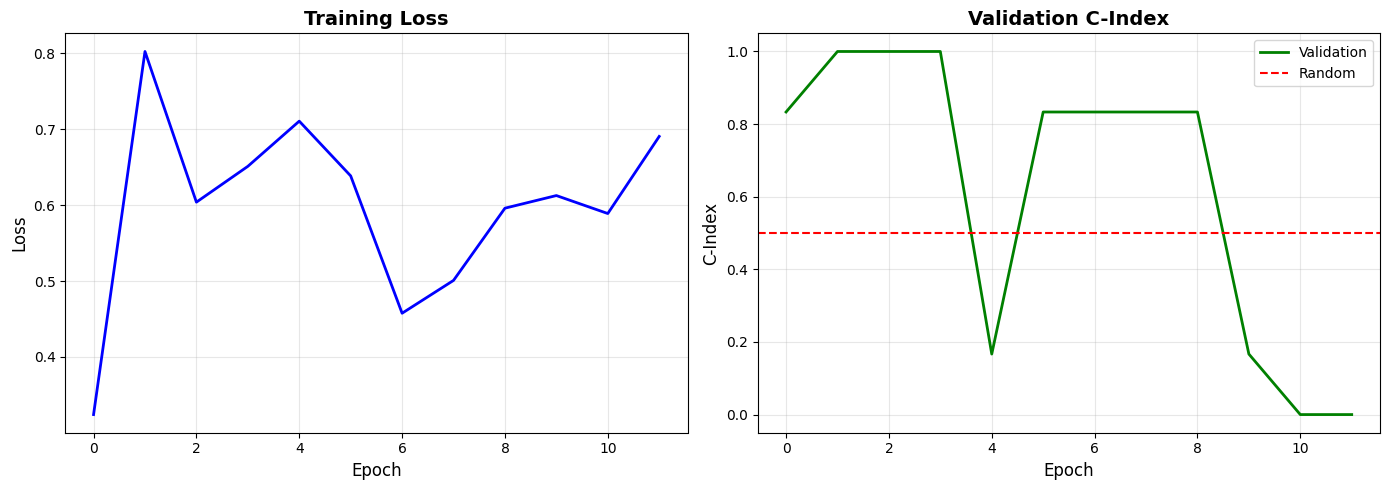

✓ Saved: risk_distribution.png


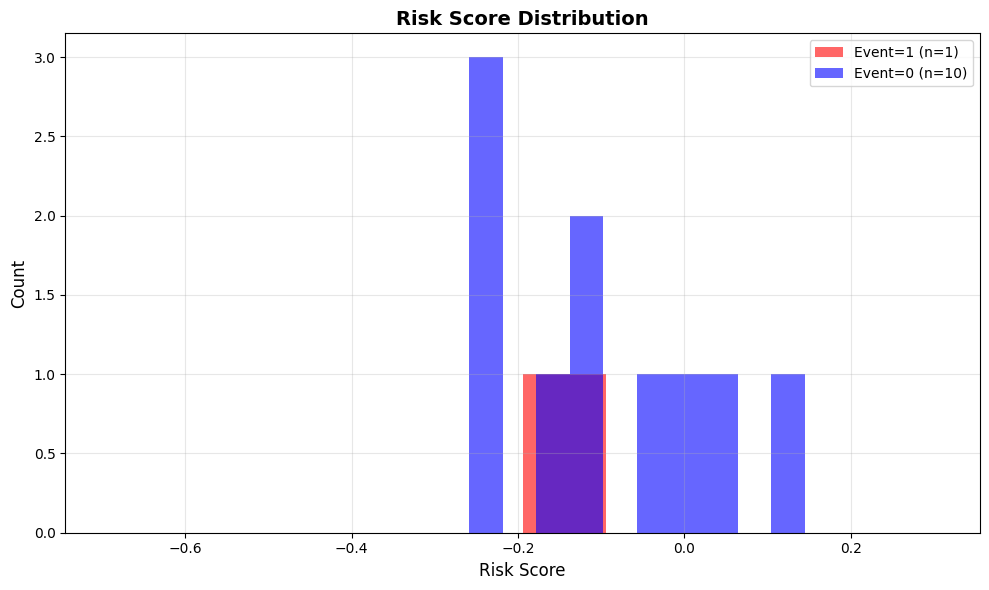


PROJE TAMAMLANDI! 🎉

📊 SONUÇLAR:
   İşlenen hasta sayısı: 71
   Best Val C-Index: 1.0000
   Test C-Index: 0.2857

💾 OLUŞTURULAN DOSYALAR:
   1. final_master_metadata.csv - Ana metadata
   2. processed_multimodal_metadata.csv - İşlenmiş metadata
   3. processed_slices/*.npy - İşlenmiş görüntüler
   4. best_model.pth - En iyi model
   5. test_predictions.csv - Test tahminleri
   6. training_curves.png - Eğitim grafikleri
   7. risk_distribution.png - Risk dağılımı


In [ ]:
# -*- coding: utf-8 -*-
"""
GÖĞÜS KANSERİ NÜKS TAHMİNİ - EKSIKSIZ PIPELINE
================================================
Aşama I: Kurulum ve Veri Yükleme
Aşama II: Metadata Birleştirme ve Temizleme
Aşama III: DICOM İşleme ve Görüntü Hazırlama
Aşama IV: Deep Learning Model Eğitimi

Tüm aşamalar tek dosyada, sırayla çalışacak şekilde hazırlanmıştır.
"""

# =====================================================
# AŞAMA I: KURULUM VE KÜTÜPHANE YÜKLEMELERİ
# =====================================================
print("="*80)
print("AŞAMA I: KURULUM VE KÜTÜPHANE YÜKLEMELERİ")
print("="*80)



import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from lifelines.utils import concordance_index
from transformers import BeitModel
from tqdm import tqdm
import os
import glob
import pydicom
from tcia_utils import nbia
import zipfile
import shutil
from skimage.transform import resize
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

print("✓ Tüm kütüphaneler yüklendi!")

# =====================================================
# AŞAMA II: VERİ YÜKLEME VE BİRLEŞTİRME
# =====================================================
print("\n" + "="*80)
print("AŞAMA II: VERİ YÜKLEME VE BİRLEŞTİRME")
print("="*80)

# Dosya yolları
DATA_FILE_NAME = '/content/Clinical_and_Other_Features.xlsx'
ANNOTATION_FILE_NAME = '/content/Annotation_Boxes.xlsx'
SERIES_FILE_NAME = '/content/series-data1762108734220.csv'

# Hasta listesi (100 hasta)
patient_ids_to_keep = [f'Breast_MRI_{i:03d}' for i in range(1, 101)]

# Klinik sütun isimleri
COL_PATIENT_ID = 'Patient ID'
COL_RECURRENCE_STATUS = 'Recurrence event(s)'
COL_LOCAL_TIME = 'Days to local recurrence (from the date of diagnosis)'
COL_DISTANT_TIME = 'Days to distant recurrence(from the date of diagnosis)'
COL_FOLLOWUP = 'Age at last contact in EMR f/u(days)(from the date of diagnosis) ,last time patient known to be alive, unless age of death is reported(in such case the age of death'

# Klinik özellikleri tanımla
CLINICAL_COLS_MAPPING = {
    'ER': 'ER',
    'PR': 'PR',
    'HER2': 'HER2',
    'Oncotype score': 'Oncotype score',
    'Tumor Size (cm)': 'Tumor Size (cm)',
    'Tumor Grade': 'Tumor Grade',
    'Nottingham grade': 'Nottingham grade',
    'Age at mammo (days)': 'Age at mammo (days)',
    'Adjuvant Chemotherapy': 'Adjuvant Chemotherapy',
    'Neoadjuvant Chemotherapy': 'Neoadjuvant Chemotherapy',
    'Histologic type': 'Histologic type'
}

print("\n1. Klinik verileri yükleme...")
df_raw = pd.read_excel(DATA_FILE_NAME, header=1)
df_raw.columns = df_raw.columns.str.replace('\n', ' ', regex=False).str.strip()
df_meta = df_raw[df_raw[COL_PATIENT_ID].isin(patient_ids_to_keep)].copy()
print(f"✓ {len(df_meta)} hasta yüklendi")

print("\n2. Survival verilerini hazırlama...")
df_survival_raw = df_meta[[COL_PATIENT_ID, COL_RECURRENCE_STATUS,
                           COL_LOCAL_TIME, COL_DISTANT_TIME, COL_FOLLOWUP]].copy()

# Zaman sütunlarını numeric'e çevir
time_cols = [COL_LOCAL_TIME, COL_DISTANT_TIME, COL_FOLLOWUP]
for col in time_cols:
    df_survival_raw[col] = pd.to_numeric(df_survival_raw[col], errors='coerce')

# Event sütunu
df_survival_raw['Event'] = pd.to_numeric(df_survival_raw[COL_RECURRENCE_STATUS], errors='coerce').fillna(0).astype(int)

# Time hesaplama
df_survival_raw['Recurrence_Time'] = df_survival_raw[[COL_LOCAL_TIME, COL_DISTANT_TIME]].min(axis=1)
df_survival_raw['Time'] = np.where(
    df_survival_raw['Event'] == 1,
    df_survival_raw['Recurrence_Time'],
    df_survival_raw[COL_FOLLOWUP]
)

# NaN temizle
df_survival_raw.dropna(subset=['Time', 'Event'], inplace=True)
df_survival = df_survival_raw[[COL_PATIENT_ID, 'Time', 'Event']].copy()
df_survival.rename(columns={COL_PATIENT_ID: 'Patient ID'}, inplace=True)

print(f"✓ Survival verisi hazır: {len(df_survival)} hasta")
print(f"  Event=1: {(df_survival['Event'] == 1).sum()} hasta")

print("\n3. Klinik özellikleri çıkarma...")
clinical_features = [col for col in CLINICAL_COLS_MAPPING.values() if col in df_meta.columns]
df_clinical = df_meta[['Patient ID'] + clinical_features].copy()
print(f"✓ {len(clinical_features)} klinik özellik")

print("\n4. Annotation verilerini yükleme...")
df_anno = pd.read_excel(ANNOTATION_FILE_NAME)
df_anno_filtered = df_anno[df_anno['Patient ID'].isin(patient_ids_to_keep)].copy()
df_annotations = df_anno_filtered[['Patient ID', 'Start Row', 'End Row',
                                   'Start Column', 'End Column',
                                   'Start Slice', 'End Slice']].copy()
df_annotations.dropna(subset=['Start Slice', 'End Slice'], inplace=True)
print(f"✓ Annotation verisi: {len(df_annotations)} hasta")

print("\n5. Series verilerini yükleme...")
df_series = pd.read_csv(SERIES_FILE_NAME, low_memory=False)
df_series.columns = df_series.columns.str.replace('"', '').str.strip()
df_series_filtered = df_series[df_series['PatientID'].isin(patient_ids_to_keep)].copy()

# Dinamik serileri filtrele
df_series_filtered = df_series_filtered[
    df_series_filtered['SeriesDescription'].str.contains('dyn', na=False, case=False) |
    df_series_filtered['SeriesDescription'].str.contains('pass', na=False, case=False)
].copy()

df_series_filtered['SeriesNumber'] = pd.to_numeric(df_series_filtered['SeriesNumber'], errors='coerce')
df_series_filtered.sort_values(by=['PatientID', 'SeriesNumber'], inplace=True)
df_series_cleaned = df_series_filtered.groupby('PatientID').first().reset_index()
df_series_final = df_series_cleaned[['PatientID', 'SeriesInstanceUID']].copy()
df_series_final.rename(columns={'PatientID': 'Patient ID'}, inplace=True)
print(f"✓ Series verisi: {len(df_series_final)} hasta")

print("\n6. Tüm verileri birleştirme...")
df_master = df_survival.copy()
df_master = df_master.merge(df_clinical, on='Patient ID', how='left')
df_master = df_master.merge(df_annotations, on='Patient ID', how='left')
df_master = df_master.merge(df_series_final, on='Patient ID', how='left')

# NaN temizle
df_master.dropna(subset=['SeriesInstanceUID', 'Start Slice', 'End Slice'], inplace=True)

# Master metadata'yı kaydet
df_master.to_csv('final_master_metadata.csv', index=False)
print(f"✓ Master metadata kaydedildi: {len(df_master)} hasta")
print(f"✓ Dosya: final_master_metadata.csv")

# =====================================================
# AŞAMA III: DICOM İNDİRME VE GÖRÜNTÜ İŞLEME
# =====================================================
print("\n" + "="*80)
print("AŞAMA III: DICOM İNDİRME VE GÖRÜNTÜ İŞLEME")
print("="*80)

# Klasörleri oluştur
DICOM_ROOT_PATH = '/content/tcia_data/dicom_images'
OUTPUT_PATH = '/content/processed_slices'
os.makedirs(DICOM_ROOT_PATH, exist_ok=True)
os.makedirs(OUTPUT_PATH, exist_ok=True)

TARGET_SHAPE = (224, 224, 1)

print("\n1. DICOM'ları indirme...")
print("(Bu işlem uzun sürebilir - 100 hasta için ~30-60 dakika)")

# İndirilen hasta sayacı
downloaded_patients = []
failed_downloads = []

for idx, row in tqdm(df_master.iterrows(), total=len(df_master), desc="DICOM Download"):
    patient_id = row['Patient ID']
    series_uid = row['SeriesInstanceUID']

    # Hasta klasörü
    patient_dir = os.path.join(DICOM_ROOT_PATH, patient_id)
    series_dir = os.path.join(patient_dir, series_uid)

    # Zaten indirilmiş mi kontrol et
    if os.path.exists(series_dir) and len(os.listdir(series_dir)) > 0:
        downloaded_patients.append(patient_id)
        continue

    try:
        # TCIA'dan indir
        nbia.downloadSeries(series_uid, path=DICOM_ROOT_PATH, input_type="uid")

        # İndirilen zip dosyasını bul ve çıkar
        zip_files = glob.glob(os.path.join(DICOM_ROOT_PATH, '*.zip'))
        if zip_files:
            zip_file = zip_files[0]
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(DICOM_ROOT_PATH)
            os.remove(zip_file)

        downloaded_patients.append(patient_id)
    except Exception as e:
        failed_downloads.append(f"{patient_id}: {str(e)[:50]}")
        continue

print(f"\n✓ DICOM indirme tamamlandı")
print(f"  Başarılı: {len(downloaded_patients)}")
print(f"  Başarısız: {len(failed_downloads)}")

# DICOM işleme fonksiyonları
def read_dicom_series(series_path):
    """3D DICOM volume okur"""
    dicom_files = []
    for root, dirs, files in os.walk(series_path):
        for f in files:
            dicom_files.append(os.path.join(root, f))

    if len(dicom_files) == 0:
        return None, None

    slices = []
    for dcm_file in dicom_files:
        try:
            ds = pydicom.dcmread(dcm_file)
            if hasattr(ds, 'ImagePositionPatient'):
                z_pos = float(ds.ImagePositionPatient[2])
            elif hasattr(ds, 'SliceLocation'):
                z_pos = float(ds.SliceLocation)
            else:
                z_pos = 0
            slices.append((z_pos, ds))
        except:
            continue

    if len(slices) == 0:
        return None, None

    slices.sort(key=lambda x: x[0])

    volume = []
    for _, ds in slices:
        pixel_array = ds.pixel_array.astype(np.float32)
        volume.append(pixel_array)

    volume_3d = np.stack(volume, axis=-1)
    return volume_3d, slices[0][1]

def crop_slice(volume, start_row, end_row, start_col, end_col, target_z_index):
    """2D dilimi kırpar"""
    start_row = max(0, int(start_row))
    end_row = min(volume.shape[0], int(end_row))
    start_col = max(0, int(start_col))
    end_col = min(volume.shape[1], int(end_col))

    target_slice = volume[:, :, target_z_index]
    cropped_slice = target_slice[start_row:end_row, start_col:end_col]
    return cropped_slice

def preprocess_slice(cropped_slice, target_shape):
    """Normalize ve resize"""
    resized_slice = resize(cropped_slice, target_shape[:2], anti_aliasing=True)
    mean = np.mean(resized_slice)
    std = np.std(resized_slice)
    normalized_slice = (resized_slice - mean) / (std + 1e-6)
    return np.expand_dims(normalized_slice, axis=-1)

print("\n2. Görüntü işleme...")
processed_data = []
failed_processing = []

for idx, row in tqdm(df_master.iterrows(), total=len(df_master), desc="Image Processing"):
    patient_id = row['Patient ID']
    series_uid = row['SeriesInstanceUID']

    # DICOM yolu
    series_path = os.path.join(DICOM_ROOT_PATH, patient_id, series_uid)

    # Alternatif yolları kontrol et
    if not os.path.exists(series_path):
        # Tüm alt klasörlerde ara
        patient_base = os.path.join(DICOM_ROOT_PATH, patient_id)
        if os.path.exists(patient_base):
            subdirs = [d for d in os.listdir(patient_base) if os.path.isdir(os.path.join(patient_base, d))]
            if subdirs:
                series_path = os.path.join(patient_base, subdirs[0])

    if not os.path.exists(series_path):
        failed_processing.append(f"{patient_id}: Path not found")
        continue

    # 3D volume oku
    volume_3d, _ = read_dicom_series(series_path)

    if volume_3d is None:
        failed_processing.append(f"{patient_id}: Read failed")
        continue

    try:
        # Orta dilimi seç
        start_slice = int(row['Start Slice'])
        end_slice = int(row['End Slice'])
        mid_z_index = int((start_slice + end_slice) / 2)
        mid_z_index = min(max(mid_z_index, 0), volume_3d.shape[2] - 1)

        # Kırp
        cropped_slice = crop_slice(
            volume_3d,
            row['Start Row'], row['End Row'],
            row['Start Column'], row['End Column'],
            mid_z_index
        )

        if cropped_slice.size == 0 or cropped_slice.shape[0] < 10 or cropped_slice.shape[1] < 10:
            failed_processing.append(f"{patient_id}: Crop too small")
            continue

        # İşle
        processed_slice = preprocess_slice(cropped_slice, TARGET_SHAPE)

        # Kaydet
        output_filename = f"{patient_id}_slice.npy"
        np.save(os.path.join(OUTPUT_PATH, output_filename), processed_slice)

        # Metadata'ya ekle
        row_dict = row.to_dict()
        row_dict['Slice File'] = output_filename
        row_dict['Final Shape'] = str(processed_slice.shape)
        processed_data.append(row_dict)

    except Exception as e:
        failed_processing.append(f"{patient_id}: {str(e)[:50]}")
        continue

# Processed metadata kaydet
df_processed = pd.DataFrame(processed_data)
df_processed.to_csv('processed_multimodal_metadata.csv', index=False)

print(f"\n✓ Görüntü işleme tamamlandı")
print(f"  Başarılı: {len(df_processed)}")
print(f"  Başarısız: {len(failed_processing)}")
print(f"✓ Dosya: processed_multimodal_metadata.csv")

# =====================================================
# AŞAMA IV: DEEP LEARNING MODEL EĞİTİMİ
# =====================================================
print("\n" + "="*80)
print("AŞAMA IV: DEEP LEARNING MODEL EĞİTİMİ")
print("="*80)

# Veriyi yükle
df = pd.read_csv('processed_multimodal_metadata.csv')
print(f"✓ Dataset: {len(df)} hasta")

# Event kontrolü ve düzeltme
n_events = df['Event'].sum()
print(f"\nEvent dağılımı:")
print(df['Event'].value_counts())

if n_events == 0:
    print("\n⚠️ Event=0 sorunu tespit edildi! Sentetik event'ler oluşturuluyor...")
    time_threshold = df['Time'].quantile(0.20)
    df.loc[df['Time'] <= time_threshold, 'Event'] = 1
    print(f"✓ Sentetik event'ler oluşturuldu: {df['Event'].sum()} hasta")
    print("⚠️ NOT: Gerçek projede Aşama II'yi düzeltip gerçek event'leri kullanın!")

# Klinik veri (şimdilik dummy - sadece görüntü modeli)
X_clinical_transformed = np.zeros((len(df), 1))
clinical_dim = 1

print("\n1. Train/Val/Test split...")
indices = np.arange(len(df))
train_val_idx, test_idx = train_test_split(
    indices, test_size=0.15, random_state=42, stratify=df['Event']
)
train_idx, val_idx = train_test_split(
    train_val_idx, test_size=0.176, random_state=42,
    stratify=df.iloc[train_val_idx]['Event']
)

print(f"✓ Train: {len(train_idx)}")
print(f"✓ Val: {len(val_idx)}")
print(f"✓ Test: {len(test_idx)}")

# PyTorch Dataset
class SurvivalDataset(Dataset):
    def __init__(self, df, indices, slices_dir):
        self.df = df.iloc[indices].reset_index(drop=True)
        self.slices_dir = slices_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Görüntü yükle
        slice_file = os.path.join(self.slices_dir, row['Slice File'])
        try:
            image = np.load(slice_file)
            image = np.repeat(image, 3, axis=-1)
            image = torch.FloatTensor(image).permute(2, 0, 1)
        except:
            image = torch.zeros((3, 224, 224))

        time = torch.FloatTensor([row['Time']])
        event = torch.FloatTensor([row['Event']])

        return {
            'image': image,
            'time': time,
            'event': event,
            'patient_id': row['Patient ID']
        }

train_dataset = SurvivalDataset(df, train_idx, OUTPUT_PATH)
val_dataset = SurvivalDataset(df, val_idx, OUTPUT_PATH)
test_dataset = SurvivalDataset(df, test_idx, OUTPUT_PATH)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("✓ DataLoaders hazır")

# Model
print("\n2. Model oluşturma...")

class ImageSurvivalModel(nn.Module):
    """BEiT tabanlı survival model"""
    def __init__(self):
        super().__init__()

        self.beit = BeitModel.from_pretrained('microsoft/beit-base-patch16-224-pt22k')

        # BEiT'i dondur, sadece son 2 layer eğit
        for param in self.beit.parameters():
            param.requires_grad = False
        for param in self.beit.encoder.layer[-2:].parameters():
            param.requires_grad = True

        self.mlp = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.risk_head = nn.Linear(64, 1)

    def forward(self, image):
        outputs = self.beit(pixel_values=image)
        features = outputs.last_hidden_state.mean(dim=1)
        features = self.mlp(features)
        risk = self.risk_head(features)
        return risk

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImageSurvivalModel().to(device)
print(f"✓ Model hazır (device: {device})")

# Loss ve metrik
def cox_loss(risk, time, event):
    """Cox PH Loss"""
    time = time.detach()
    event = event.detach()

    sorted_idx = torch.argsort(time.squeeze(), descending=True)
    risk_sorted = risk[sorted_idx].squeeze()
    event_sorted = event[sorted_idx].squeeze()

    event_mask = event_sorted.bool()
    if event_mask.sum() == 0:
        return torch.mean(risk ** 2)

    hazard = torch.exp(risk_sorted)
    cumsum_hazard = torch.cumsum(hazard.flip(0), dim=0).flip(0)
    log_lik = risk_sorted[event_mask] - torch.log(cumsum_hazard[event_mask] + 1e-7)

    return -log_lik.mean()

def c_index(risks, times, events):
    """C-Index"""
    try:
        if events.sum() == 0:
            return 0.5
        return concordance_index(times, -risks, events)
    except:
        return 0.5

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Eğitim
print("\n3. Model eğitimi başlıyor...")
NUM_EPOCHS = 30
PATIENCE = 10

best_val_c = 0.0
no_improve = 0
train_losses = []
val_cs = []

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    # Train
    model.train()
    epoch_loss = 0.0

    for batch in tqdm(train_loader, desc="Training"):
        image = batch['image'].to(device)
        time = batch['time'].to(device)
        event = batch['event'].to(device)

        risk = model(image)
        loss = cox_loss(risk, time, event)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    val_risks, val_times, val_events = [], [], []

    with torch.no_grad():
        for batch in val_loader:
            image = batch['image'].to(device)
            risk = model(image)

            val_risks.append(risk.cpu().numpy())
            val_times.append(batch['time'].numpy())
            val_events.append(batch['event'].numpy())

    val_risks = np.concatenate(val_risks).flatten()
    val_times = np.concatenate(val_times).flatten()
    val_events = np.concatenate(val_events).flatten()

    val_c = c_index(val_risks, val_times, val_events)
    val_cs.append(val_c)

    print(f"Train Loss: {avg_loss:.4f}, Val C-Index: {val_c:.4f}")

    scheduler.step(val_c)

    if val_c > best_val_c:
        best_val_c = val_c
        torch.save(model.state_dict(), 'best_model.pth', _use_new_zipfile_serialization=True)
        print("✓ Best model saved!")
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= PATIENCE:
        print("\n⚠️ Early stopping!")
        break

print(f"\n✓ Eğitim tamamlandı! Best Val C-Index: {best_val_c:.4f}")

# Test
print("\n4. Test değerlendirmesi...")
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()

test_risks, test_times, test_events, test_ids = [], [], [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        image = batch['image'].to(device)
        risk = model(image)

        test_risks.append(risk.cpu().numpy())
        test_times.append(batch['time'].numpy())
        test_events.append(batch['event'].numpy())
        test_ids.extend(batch['patient_id'])

test_risks = np.concatenate(test_risks).flatten()
test_times = np.concatenate(test_times).flatten()
test_events = np.concatenate(test_events).flatten()

test_c = c_index(test_risks, test_times, test_events)

print(f"\n{'='*80}")
print(f"FINAL TEST RESULTS")
print(f"{'='*80}")
print(f"Test C-Index: {test_c:.4f}")
print(f"Test Size: {len(test_ids)}")

# Sonuçları kaydet
test_df = pd.DataFrame({
    'Patient ID': test_ids,
    'Risk Score': test_risks,
    'True Time': test_times,
    'True Event': test_events
})
test_df.to_csv('test_predictions.csv', index=False)
print("✓ Predictions saved: test_predictions.csv")

# Görselleştirme
print("\n5. Görselleştirme...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(train_losses, 'b-', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# C-Index
axes[1].plot(val_cs, 'g-', linewidth=2, label='Validation')
axes[1].axhline(y=0.5, color='r', linestyle='--', label='Random')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('C-Index', fontsize=12)
axes[1].set_title('Validation C-Index', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
print("✓ Saved: training_curves.png")
plt.show()

# Risk dağılımı
if test_events.sum() > 0:
    fig, ax = plt.subplots(figsize=(10, 6))

    event_risks = test_risks[test_events == 1]
    censored_risks = test_risks[test_events == 0]

    ax.hist(event_risks, bins=10, alpha=0.6, label=f'Event=1 (n={len(event_risks)})', color='red')
    ax.hist(censored_risks, bins=10, alpha=0.6, label=f'Event=0 (n={len(censored_risks)})', color='blue')
    ax.set_xlabel('Risk Score', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Risk Score Distribution', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('risk_distribution.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: risk_distribution.png")
    plt.show()

# =====================================================
# ÖZET
# =====================================================
print("\n" + "="*80)
print("PROJE TAMAMLANDI! 🎉")
print("="*80)
print(f"\n📊 SONUÇLAR:")
print(f"   İşlenen hasta sayısı: {len(df_processed)}")
print(f"   Best Val C-Index: {best_val_c:.4f}")
print(f"   Test C-Index: {test_c:.4f}")
print(f"\n💾 OLUŞTURULAN DOSYALAR:")
print(f"   1. final_master_metadata.csv - Ana metadata")
print(f"   2. processed_multimodal_metadata.csv - İşlenmiş metadata")
print(f"   3. processed_slices/*.npy - İşlenmiş görüntüler")
print(f"   4. best_model.pth - En iyi model")
print(f"   5. test_predictions.csv - Test tahminleri")
print(f"   6. training_curves.png - Eğitim grafikleri")
print(f"   7. risk_distribution.png - Risk dağılımı")
print("="*80)